<a href="https://colab.research.google.com/github/haleykahn14/NFL-Salary-Cap/blob/main/salary_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NFL SALARY CAP NEURAL NETWORK

[STEP 1] Loading data...
Loaded 36544 salary records
Years: 2013 - 2022

[STEP 2] Engineering features...
Created 319 team-year feature sets
Number of features: 12

[STEP 3] Merging with win percentage data...
Merged data: 319 records
Teams: 32
Years: 2013 - 2022

[STEP 4] Preparing training data...
Feature matrix shape: (319, 12)
Target shape: (319,)

Features used:
  1. total_salary
  2. top1_pct
  3. top3_pct
  4. top5_pct
  5. top10_pct
  6. top15_pct
  7. salary_gini
  8. salary_std
  9. salary_cv
  10. num_players
  11. median_salary
  12. bottom_half_pct

[STEP 5] Splitting and scaling data...
Training set: 223 samples
Validation set: 48 samples
Test set: 48 samples

[STEP 6] Building neural network...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training neural network...

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 125: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 163: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 183: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 197: early stopping
Restoring model weights from the end of the best epoch: 147.

Training completed in 197 epochs

[STEP 8] Evaluating model performance...

Training Set:
  R² Score: 0.3735
  RMSE: 0.1491 (2.38 wins in 16-game season)
  MAE: 0.1218 (1.95 wins in 16-game season)

Validation Set:
  R² Score: 0.0711
  RMSE: 0.1771 (2.83 wins in 16-game season)
  MAE: 0.1484 (2.38 wins in 16-game season)

Test Set:
  R² Score: 0.3335
  RMSE: 0.1526 (2.44 wins in 16-game season)
  MAE: 0.1220 (1.95 wins in 16-game season)

[STEP 9] Creating visualizations...

Visualization saved as: neural_network_results.png


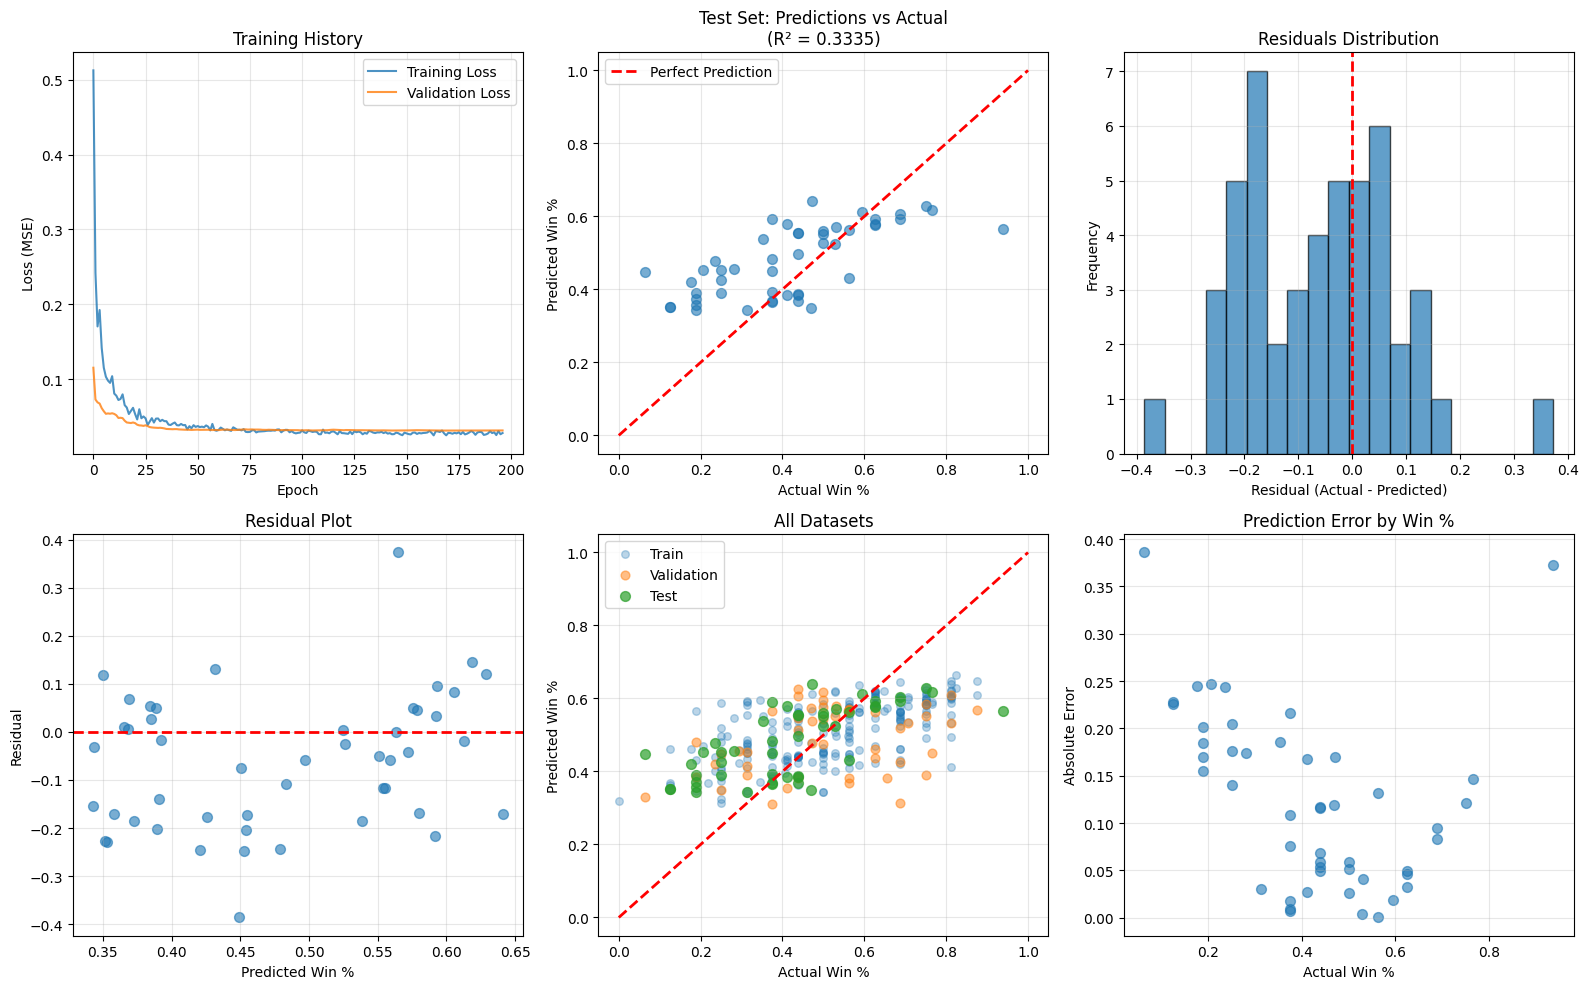


[STEP 10] Analyzing feature importance...

Feature Importance (Top 10):
        feature  importance
  median_salary    0.662545
    salary_gini    0.109300
    num_players    0.085447
       top1_pct    0.057541
      top15_pct    0.035768
       top3_pct    0.018475
   total_salary    0.013149
      salary_cv    0.005012
     salary_std    0.000456
bottom_half_pct   -0.005033

Feature importance plot saved as: feature_importance.png


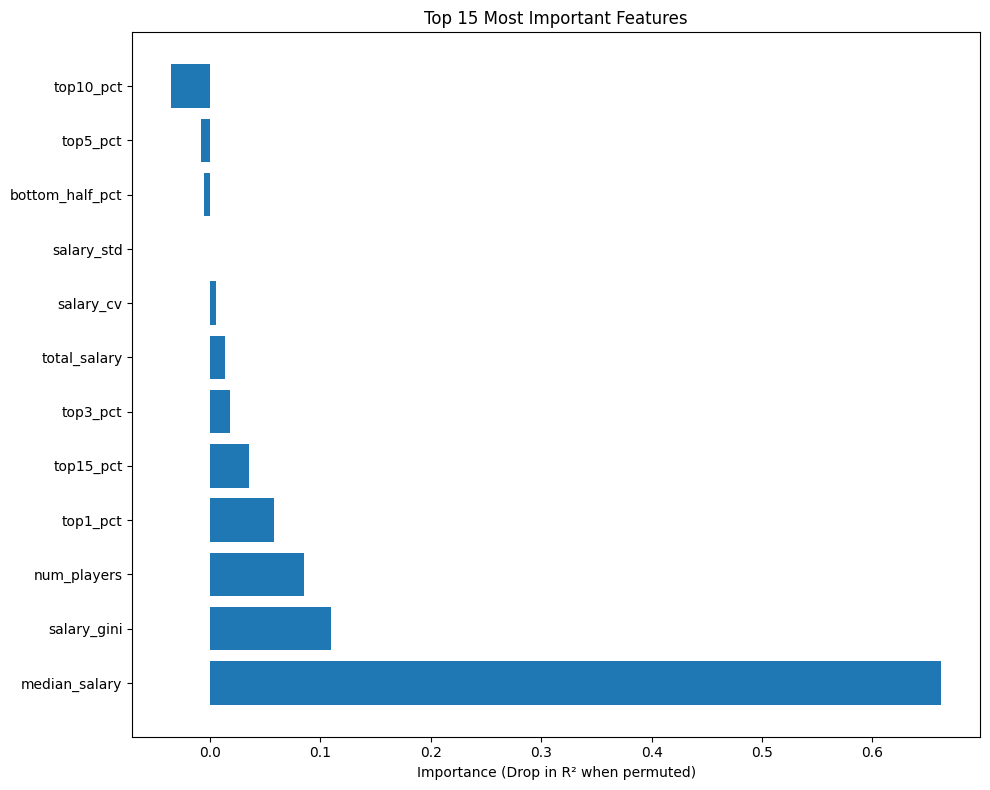


ANALYSIS COMPLETE!

Next steps:
1. Review the visualizations to understand model performance
2. Check feature importance to see what matters most
3. If R² is low, try: more data, different features, or deeper network
4. Compare these results to your linear regression baseline


In [ ]:
# just salary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*60)
print("NFL SALARY CAP NEURAL NETWORK")
print("="*60)

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n[STEP 1] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

# Clean salary data
salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"Loaded {len(salary_data)} salary records")
print(f"Years: {salary_data['year'].min():.0f} - {salary_data['year'].max():.0f}")

# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 2] Engineering features...")

# Define helper function for Gini coefficient
def calculate_gini(salaries):
    """Calculate Gini coefficient for salary inequality"""
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

# Calculate various salary distribution metrics
features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features = {
        'team': team,
        'year': year,
        'total_salary': total_salary,

        # Top players percentages
        'top1_pct': (salaries_sorted[0] / total_salary * 100) if len(salaries_sorted) >= 1 else 0,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'top5_pct': (salaries_sorted[:5].sum() / total_salary * 100) if len(salaries_sorted) >= 5 else 0,
        'top10_pct': (salaries_sorted[:10].sum() / total_salary * 100) if len(salaries_sorted) >= 10 else 0,
        'top15_pct': (salaries_sorted[:15].sum() / total_salary * 100) if len(salaries_sorted) >= 15 else 0,

        # Salary distribution metrics
        'salary_gini': calculate_gini(salaries_sorted),  # Inequality measure
        'salary_std': np.std(salaries_sorted),
        'salary_cv': np.std(salaries_sorted) / np.mean(salaries_sorted) if np.mean(salaries_sorted) > 0 else 0,  # Coefficient of variation

        # Squad depth metrics
        'num_players': len(salaries_sorted),
        'median_salary': np.median(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    }

    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} team-year feature sets")
print(f"Number of features: {len(features_df.columns) - 2}")  # Minus team and year

# ============================================================================
# STEP 3: MERGE WITH WIN DATA
# ============================================================================

print("\n[STEP 3] Merging with win percentage data...")

# Clean team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

# Merge datasets
merged_data = pd.merge(
    features_df,
    team_stats[['Team', 'Season', 'W_PCT', 'W', 'PF', 'PA']],
    left_on=['team', 'year'],
    right_on=['Team', 'Season'],
    how='inner'
)

print(f"Merged data: {len(merged_data)} records")
print(f"Teams: {merged_data['team'].nunique()}")
print(f"Years: {merged_data['year'].min():.0f} - {merged_data['year'].max():.0f}")

if len(merged_data) == 0:
    print("\nERROR: No matching records! Check team names and years.")
    exit()

# ============================================================================
# STEP 4: PREPARE FEATURES AND TARGET
# ============================================================================

print("\n[STEP 4] Preparing training data...")

# Select feature columns (exclude identifiers and target)
feature_columns = [col for col in features_df.columns if col not in ['team', 'year']]
X = merged_data[feature_columns].values
y = merged_data['W_PCT'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# STEP 5: SPLIT AND SCALE DATA
# ============================================================================

print("\n[STEP 5] Splitting and scaling data...")

# Split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features (important for neural networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 6: BUILD NEURAL NETWORK
# ============================================================================

print("\n[STEP 6] Building neural network...")

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # Hidden layers with dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),

    # Output layer (regression - predicting win percentage)
    layers.Dense(1, activation='linear')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel Architecture:")
model.summary()

# ============================================================================
# STEP 7: TRAIN THE MODEL
# ============================================================================

print("\n[STEP 7] Training neural network...")

# Callbacks for better training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=0  # Set to 1 to see epoch-by-epoch progress
)

print(f"\nTraining completed in {len(history.history['loss'])} epochs")

# ============================================================================
# STEP 8: EVALUATE THE MODEL
# ============================================================================

print("\n[STEP 8] Evaluating model performance...")

# Predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f} ({rmse*16:.2f} wins in 16-game season)")
    print(f"  MAE: {mae:.4f} ({mae*16:.2f} wins in 16-game season)")

print("="*60)
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
print("="*60)

# ============================================================================
# STEP 9: VISUALIZATIONS
# ============================================================================

print("\n[STEP 9] Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Training History
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Predictions vs Actual (Test Set)
ax2 = plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title(f'Test Set: Predictions vs Actual\n(R² = {r2_score(y_test, y_test_pred):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = plt.subplot(2, 3, 3)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
ax4 = plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, residuals, alpha=0.6, s=50)
plt.xlabel('Predicted Win %')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 5. All datasets comparison
ax5 = plt.subplot(2, 3, 5)
plt.scatter(y_train, y_train_pred, alpha=0.3, s=30, label='Train')
plt.scatter(y_val, y_val_pred, alpha=0.5, s=40, label='Validation')
plt.scatter(y_test, y_test_pred, alpha=0.7, s=50, label='Test')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title('All Datasets')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Error distribution by win percentage
ax6 = plt.subplot(2, 3, 6)
abs_errors = np.abs(residuals)
plt.scatter(y_test, abs_errors, alpha=0.6, s=50)
plt.xlabel('Actual Win %')
plt.ylabel('Absolute Error')
plt.title('Prediction Error by Win %')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as: neural_network_results.png")
plt.show()

# ============================================================================
# STEP 10: FEATURE IMPORTANCE (via permutation)
# ============================================================================

print("\n[STEP 10] Analyzing feature importance...")

baseline_score = r2_score(y_test, y_test_pred)
importance_scores = []

for i, feature in enumerate(feature_columns):
    # Shuffle one feature at a time
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Predict with shuffled feature
    y_pred_permuted = model.predict(X_test_permuted, verbose=0).flatten()
    permuted_score = r2_score(y_test, y_pred_permuted)

    # Importance = drop in performance
    importance = baseline_score - permuted_score
    importance_scores.append(importance)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Drop in R² when permuted)')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as: feature_importance.png")
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Review the visualizations to understand model performance")
print("2. Check feature importance to see what matters most")
print("3. If R² is low, try: more data, different features, or deeper network")
print("4. Compare these results to your linear regression baseline")

NFL SALARY CAP NEURAL NETWORK

[STEP 1] Loading data...
Loaded 36544 salary records
Years: 2013 - 2022

[STEP 2] Engineering features...
Created 319 team-year feature sets
Number of features: 12

[STEP 3] Merging with win percentage data...
Merged data: 319 records
Teams: 32
Years: 2013 - 2022

[STEP 4] Preparing training data...
Feature matrix shape: (319, 29)
Target shape: (319,)

Total features: 29
  - Salary distribution features: 12
  - Position group features: 17

All features used:
  1. total_salary
  2. top1_pct
  3. top3_pct
  4. top5_pct
  5. top10_pct
  6. top15_pct
  7. salary_gini
  8. salary_std
  9. salary_cv
  10. num_players
  11. median_salary
  12. bottom_half_pct
  13. QB_P
  14. RB_P
  15. WR_P
  16. TE_P
  17. OL_P
  18. IDL_P
  19. EDGE_P
  20. LB_P
  21. S_P
  22. CB_P
  23. Offense_P
  24. Defense_P
  25. Pass-Catcher_P
  26. Skill_Pos_Offense_P
  27. D-Line_P
  28. Front-7_P
  29. Secondary_P

[STEP 5] Splitting and scaling data...
Training set: 223 samples
Va

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,721 (57.50 KB)

 Trainable params: 14,721 (57.50 KB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training neural network...

Epoch 117: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 146: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 166: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 176: early stopping
Restoring model weights from the end of the best epoch: 126.

Training completed in 176 epochs

[STEP 8] Evaluating model performance...

Training Set:
  R² Score: 0.5785
  RMSE: 0.1223 (1.96 wins in 16-game season)
  MAE: 0.1026 (1.64 wins in 16-game season)

Validation Set:
  R² Score: 0.1588
  RMSE: 0.1686 (2.70 wins in 16-game season)
  MAE: 0.1422 (2.27 wins in 16-game season)

Test Set:
  R² Score: 0.3047
  RMSE: 0.1559 (2.49 wins in 16-game season)
  MAE: 0.1232 (1.97 wins in 16-game season)

[STEP 9] Creating visualizations...

Visualization saved as: neural_network_results.png


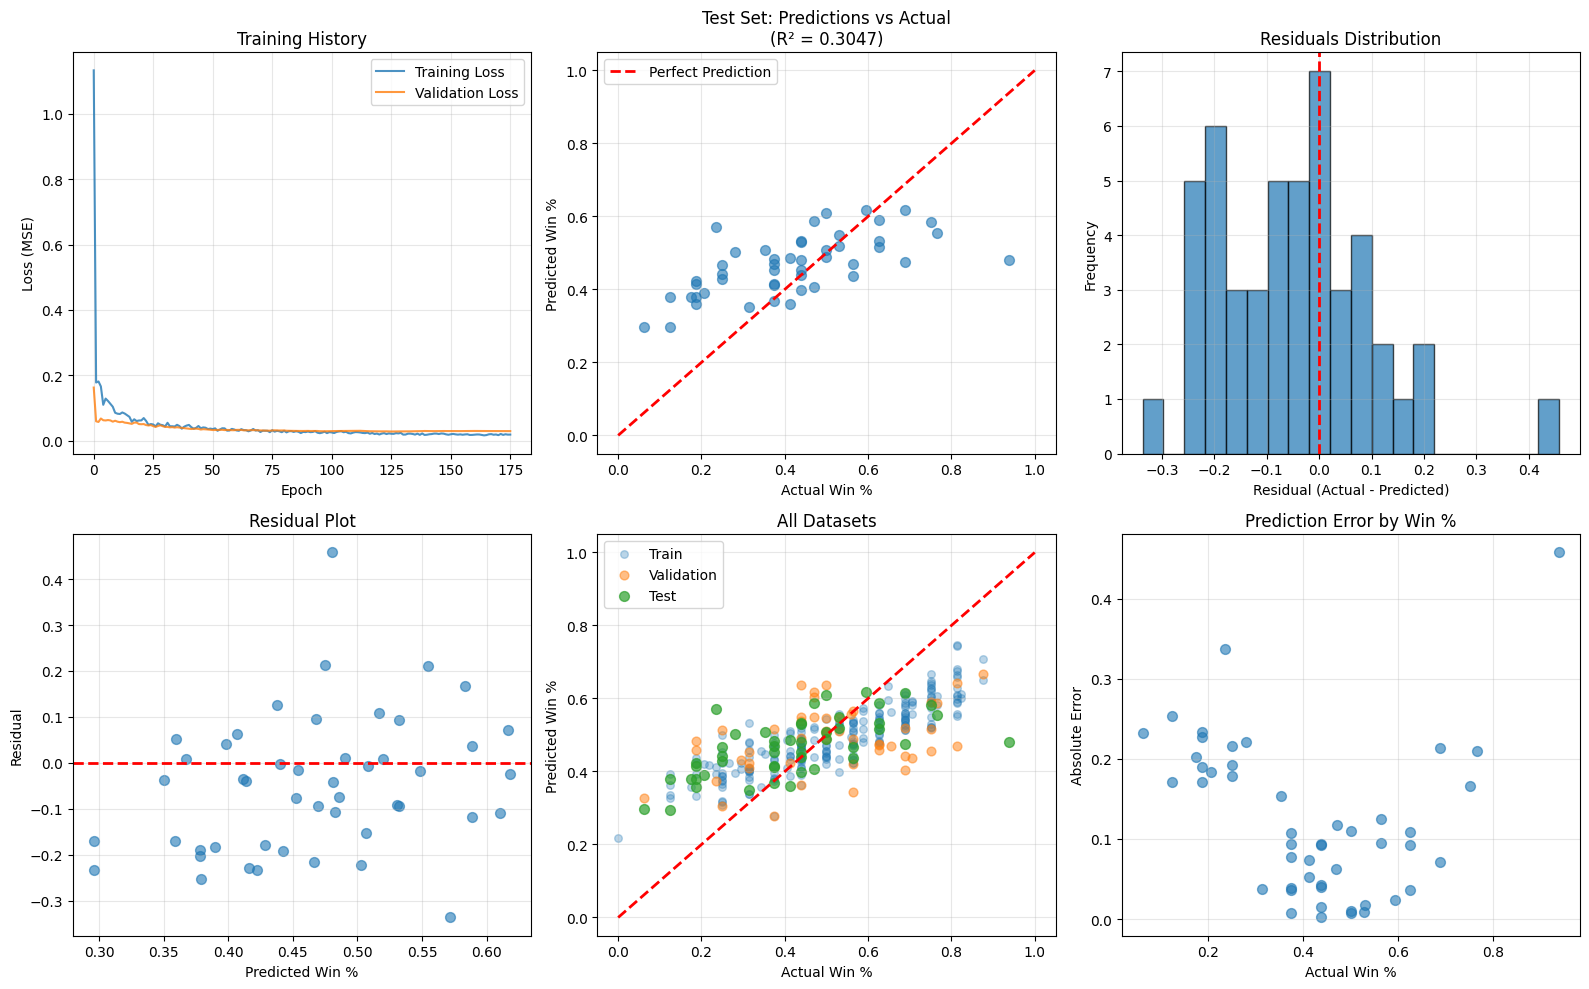


[STEP 10] Analyzing feature importance...

Feature Importance (Top 10):
      feature  importance
median_salary    0.233799
  num_players    0.109359
         LB_P    0.045324
    Defense_P    0.031979
    Front-7_P    0.026776
          S_P    0.022422
         CB_P    0.020990
  salary_gini    0.020790
  Secondary_P    0.019284
     top1_pct    0.015473

Feature importance plot saved as: feature_importance.png


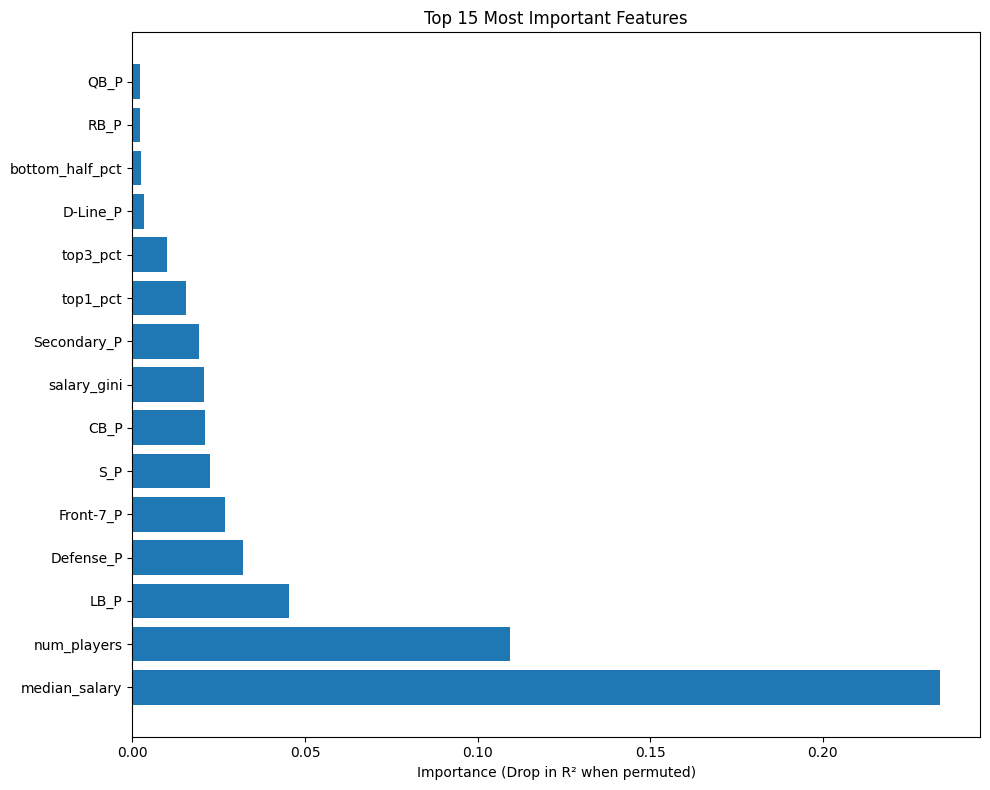


ANALYSIS COMPLETE!

Next steps:
1. Review the visualizations to understand model performance
2. Check feature importance to see what matters most
3. If R² is low, try: more data, different features, or deeper network
4. Compare these results to your linear regression baseline


In [ ]:
# salary and cap percent by positional group
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*60)
print("NFL SALARY CAP NEURAL NETWORK")
print("="*60)

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n[STEP 1] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

# Clean salary data
salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"Loaded {len(salary_data)} salary records")
print(f"Years: {salary_data['year'].min():.0f} - {salary_data['year'].max():.0f}")

# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 2] Engineering features...")

# Define helper function for Gini coefficient
def calculate_gini(salaries):
    """Calculate Gini coefficient for salary inequality"""
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

# Calculate various salary distribution metrics
features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features = {
        'team': team,
        'year': year,
        'total_salary': total_salary,

        # Top players percentages
        'top1_pct': (salaries_sorted[0] / total_salary * 100) if len(salaries_sorted) >= 1 else 0,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'top5_pct': (salaries_sorted[:5].sum() / total_salary * 100) if len(salaries_sorted) >= 5 else 0,
        'top10_pct': (salaries_sorted[:10].sum() / total_salary * 100) if len(salaries_sorted) >= 10 else 0,
        'top15_pct': (salaries_sorted[:15].sum() / total_salary * 100) if len(salaries_sorted) >= 15 else 0,

        # Salary distribution metrics
        'salary_gini': calculate_gini(salaries_sorted),  # Inequality measure
        'salary_std': np.std(salaries_sorted),
        'salary_cv': np.std(salaries_sorted) / np.mean(salaries_sorted) if np.mean(salaries_sorted) > 0 else 0,  # Coefficient of variation

        # Squad depth metrics
        'num_players': len(salaries_sorted),
        'median_salary': np.median(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    }

    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} team-year feature sets")
print(f"Number of features: {len(features_df.columns) - 2}")  # Minus team and year

# ============================================================================
# STEP 3: MERGE WITH WIN DATA
# ============================================================================

print("\n[STEP 3] Merging with win percentage data...")

# Clean team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

# Merge datasets - now include position group percentages
position_columns = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

merge_columns = ['Team', 'Season', 'W_PCT', 'W', 'PF', 'PA'] + position_columns

merged_data = pd.merge(
    features_df,
    team_stats[merge_columns],
    left_on=['team', 'year'],
    right_on=['Team', 'Season'],
    how='inner'
)

print(f"Merged data: {len(merged_data)} records")
print(f"Teams: {merged_data['team'].nunique()}")
print(f"Years: {merged_data['year'].min():.0f} - {merged_data['year'].max():.0f}")

if len(merged_data) == 0:
    print("\nERROR: No matching records! Check team names and years.")
    exit()

# ============================================================================
# STEP 4: PREPARE FEATURES AND TARGET
# ============================================================================

print("\n[STEP 4] Preparing training data...")

# Select feature columns (exclude identifiers and target)
feature_columns = [col for col in features_df.columns if col not in ['team', 'year']]

# Add position group percentage columns as features
position_group_features = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

feature_columns = feature_columns + position_group_features

X = merged_data[feature_columns].values
y = merged_data['W_PCT'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTotal features: {len(feature_columns)}")
print(f"  - Salary distribution features: {len(feature_columns) - len(position_group_features)}")
print(f"  - Position group features: {len(position_group_features)}")
print(f"\nAll features used:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# STEP 5: SPLIT AND SCALE DATA
# ============================================================================

print("\n[STEP 5] Splitting and scaling data...")

# Split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features (important for neural networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 6: BUILD NEURAL NETWORK
# ============================================================================

print("\n[STEP 6] Building neural network...")

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # Hidden layers with dropout for regularization
    # Increased capacity due to more features
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),

    # Output layer (regression - predicting win percentage)
    layers.Dense(1, activation='linear')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel Architecture:")
model.summary()

# ============================================================================
# STEP 7: TRAIN THE MODEL
# ============================================================================

print("\n[STEP 7] Training neural network...")

# Callbacks for better training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=0  # Set to 1 to see epoch-by-epoch progress
)

print(f"\nTraining completed in {len(history.history['loss'])} epochs")

# ============================================================================
# STEP 8: EVALUATE THE MODEL
# ============================================================================

print("\n[STEP 8] Evaluating model performance...")

# Predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f} ({rmse*16:.2f} wins in 16-game season)")
    print(f"  MAE: {mae:.4f} ({mae*16:.2f} wins in 16-game season)")

print("="*60)
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
print("="*60)

# ============================================================================
# STEP 9: VISUALIZATIONS
# ============================================================================

print("\n[STEP 9] Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Training History
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Predictions vs Actual (Test Set)
ax2 = plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title(f'Test Set: Predictions vs Actual\n(R² = {r2_score(y_test, y_test_pred):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = plt.subplot(2, 3, 3)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
ax4 = plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, residuals, alpha=0.6, s=50)
plt.xlabel('Predicted Win %')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 5. All datasets comparison
ax5 = plt.subplot(2, 3, 5)
plt.scatter(y_train, y_train_pred, alpha=0.3, s=30, label='Train')
plt.scatter(y_val, y_val_pred, alpha=0.5, s=40, label='Validation')
plt.scatter(y_test, y_test_pred, alpha=0.7, s=50, label='Test')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title('All Datasets')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Error distribution by win percentage
ax6 = plt.subplot(2, 3, 6)
abs_errors = np.abs(residuals)
plt.scatter(y_test, abs_errors, alpha=0.6, s=50)
plt.xlabel('Actual Win %')
plt.ylabel('Absolute Error')
plt.title('Prediction Error by Win %')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as: neural_network_results.png")
plt.show()

# ============================================================================
# STEP 10: FEATURE IMPORTANCE (via permutation)
# ============================================================================

print("\n[STEP 10] Analyzing feature importance...")

baseline_score = r2_score(y_test, y_test_pred)
importance_scores = []

for i, feature in enumerate(feature_columns):
    # Shuffle one feature at a time
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Predict with shuffled feature
    y_pred_permuted = model.predict(X_test_permuted, verbose=0).flatten()
    permuted_score = r2_score(y_test, y_pred_permuted)

    # Importance = drop in performance
    importance = baseline_score - permuted_score
    importance_scores.append(importance)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Drop in R² when permuted)')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as: feature_importance.png")
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Review the visualizations to understand model performance")
print("2. Check feature importance to see what matters most")
print("3. If R² is low, try: more data, different features, or deeper network")
print("4. Compare these results to your linear regression baseline")

NFL SALARY CAP NEURAL NETWORK

[STEP 1] Loading data...
Loaded 36544 salary records
Years: 2013 - 2022

[STEP 2] Engineering features...
Created 319 team-year feature sets
Number of features: 11

[STEP 3] Merging with win percentage data...
Merged data: 319 records
Teams: 32
Years: 2013 - 2022

[STEP 4] Preparing training data...
Feature matrix shape: (319, 28)
Target shape: (319,)

Total features: 28
  - Salary distribution features: 11
  - Position group features: 17

All features used:
  1. total_salary
  2. top1_pct
  3. top3_pct
  4. top5_pct
  5. top10_pct
  6. top15_pct
  7. salary_gini
  8. salary_std
  9. salary_cv
  10. median_salary
  11. bottom_half_pct
  12. QB_P
  13. RB_P
  14. WR_P
  15. TE_P
  16. OL_P
  17. IDL_P
  18. EDGE_P
  19. LB_P
  20. S_P
  21. CB_P
  22. Offense_P
  23. Defense_P
  24. Pass-Catcher_P
  25. Skill_Pos_Offense_P
  26. D-Line_P
  27. Front-7_P
  28. Secondary_P

[STEP 5] Splitting and scaling data...
Training set: 223 samples
Validation set: 48 s

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training neural network...

Epoch 104: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 124: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 134: early stopping
Restoring model weights from the end of the best epoch: 84.

Training completed in 134 epochs

[STEP 8] Evaluating model performance...

Training Set:
  R² Score: 0.5121
  RMSE: 0.1316 (2.10 wins in 16-game season)
  MAE: 0.1098 (1.76 wins in 16-game season)

Validation Set:
  R² Score: 0.1519
  RMSE: 0.1693 (2.71 wins in 16-game season)
  MAE: 0.1421 (2.27 wins in 16-game season)

Test Set:
  R² Score: 0.3508
  RMSE: 0.1506 (2.41 wins in 16-game season)
  MAE: 0.1202 (1.92 wins in 16-game season)

[STEP 9] Creating visualizations...

Visualization saved as: neural_network_results.png


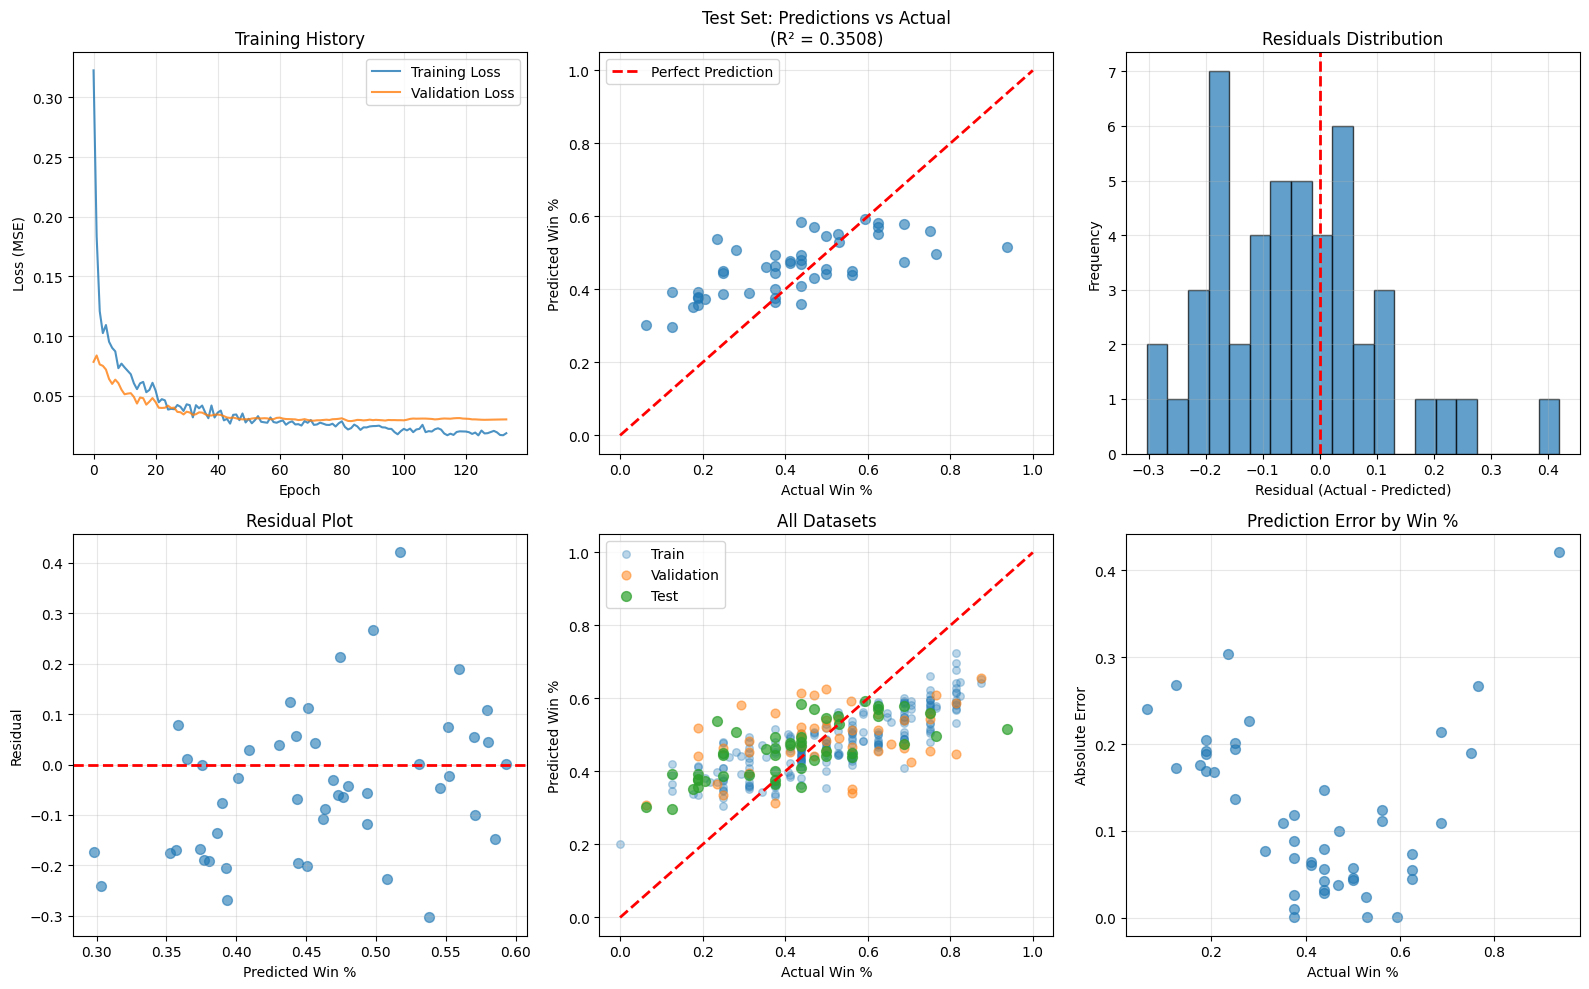


[STEP 10] Analyzing feature importance...

Feature Importance (Top 10):
      feature  importance
median_salary    0.416377
        IDL_P    0.058731
    salary_cv    0.053644
         QB_P    0.044426
       EDGE_P    0.039359
         OL_P    0.033470
         LB_P    0.028758
         TE_P    0.027204
    Front-7_P    0.024454
          S_P    0.021662

Feature importance plot saved as: feature_importance.png


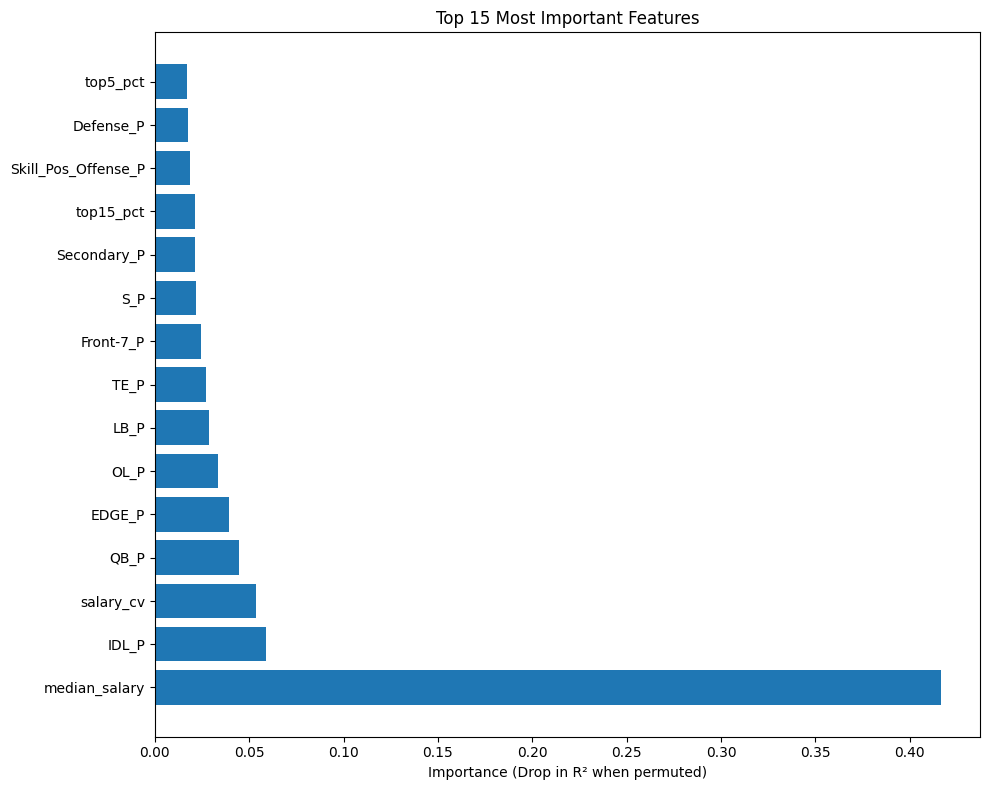


ANALYSIS COMPLETE!

Next steps:
1. Review the visualizations to understand model performance
2. Check feature importance to see what matters most
3. If R² is low, try: more data, different features, or deeper network
4. Compare these results to your linear regression baseline


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*60)
print("NFL SALARY CAP NEURAL NETWORK")
print("="*60)

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n[STEP 1] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

# Clean salary data
salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"Loaded {len(salary_data)} salary records")
print(f"Years: {salary_data['year'].min():.0f} - {salary_data['year'].max():.0f}")

# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 2] Engineering features...")

# Define helper function for Gini coefficient
def calculate_gini(salaries):
    """Calculate Gini coefficient for salary inequality"""
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

# Calculate various salary distribution metrics
features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features = {
        'team': team,
        'year': year,
        'total_salary': total_salary,

        # Top players percentages
        'top1_pct': (salaries_sorted[0] / total_salary * 100) if len(salaries_sorted) >= 1 else 0,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'top5_pct': (salaries_sorted[:5].sum() / total_salary * 100) if len(salaries_sorted) >= 5 else 0,
        'top10_pct': (salaries_sorted[:10].sum() / total_salary * 100) if len(salaries_sorted) >= 10 else 0,
        'top15_pct': (salaries_sorted[:15].sum() / total_salary * 100) if len(salaries_sorted) >= 15 else 0,

        # Salary distribution metrics
        'salary_gini': calculate_gini(salaries_sorted),  # Inequality measure
        'salary_std': np.std(salaries_sorted),
        'salary_cv': np.std(salaries_sorted) / np.mean(salaries_sorted) if np.mean(salaries_sorted) > 0 else 0,  # Coefficient of variation

        # Squad depth metrics
        'median_salary': np.median(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    }

    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} team-year feature sets")
print(f"Number of features: {len(features_df.columns) - 2}")  # Minus team and year

# ============================================================================
# STEP 3: MERGE WITH WIN DATA
# ============================================================================

print("\n[STEP 3] Merging with win percentage data...")

# Clean team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

# Merge datasets - now include position group percentages
position_columns = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

merge_columns = ['Team', 'Season', 'W_PCT', 'W', 'PF', 'PA'] + position_columns

merged_data = pd.merge(
    features_df,
    team_stats[merge_columns],
    left_on=['team', 'year'],
    right_on=['Team', 'Season'],
    how='inner'
)

print(f"Merged data: {len(merged_data)} records")
print(f"Teams: {merged_data['team'].nunique()}")
print(f"Years: {merged_data['year'].min():.0f} - {merged_data['year'].max():.0f}")

if len(merged_data) == 0:
    print("\nERROR: No matching records! Check team names and years.")
    exit()

# ============================================================================
# STEP 4: PREPARE FEATURES AND TARGET
# ============================================================================

print("\n[STEP 4] Preparing training data...")

# Select feature columns (exclude identifiers and target)
feature_columns = [col for col in features_df.columns if col not in ['team', 'year']]

# Add position group percentage columns as features
position_group_features = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

feature_columns = feature_columns + position_group_features

X = merged_data[feature_columns].values
y = merged_data['W_PCT'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTotal features: {len(feature_columns)}")
print(f"  - Salary distribution features: {len(feature_columns) - len(position_group_features)}")
print(f"  - Position group features: {len(position_group_features)}")
print(f"\nAll features used:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# STEP 5: SPLIT AND SCALE DATA
# ============================================================================

print("\n[STEP 5] Splitting and scaling data...")

# Split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features (important for neural networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 6: BUILD NEURAL NETWORK
# ============================================================================

print("\n[STEP 6] Building neural network...")

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # Hidden layers with dropout for regularization
    # Increased capacity due to more features
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),

    # Output layer (regression - predicting win percentage)
    layers.Dense(1, activation='linear')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel Architecture:")
model.summary()

# ============================================================================
# STEP 7: TRAIN THE MODEL
# ============================================================================

print("\n[STEP 7] Training neural network...")

# Callbacks for better training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=0  # Set to 1 to see epoch-by-epoch progress
)

print(f"\nTraining completed in {len(history.history['loss'])} epochs")

# ============================================================================
# STEP 8: EVALUATE THE MODEL
# ============================================================================

print("\n[STEP 8] Evaluating model performance...")

# Predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f} ({rmse*16:.2f} wins in 16-game season)")
    print(f"  MAE: {mae:.4f} ({mae*16:.2f} wins in 16-game season)")

print("="*60)
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
print("="*60)

# ============================================================================
# STEP 9: VISUALIZATIONS
# ============================================================================

print("\n[STEP 9] Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Training History
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Predictions vs Actual (Test Set)
ax2 = plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title(f'Test Set: Predictions vs Actual\n(R² = {r2_score(y_test, y_test_pred):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = plt.subplot(2, 3, 3)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
ax4 = plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, residuals, alpha=0.6, s=50)
plt.xlabel('Predicted Win %')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 5. All datasets comparison
ax5 = plt.subplot(2, 3, 5)
plt.scatter(y_train, y_train_pred, alpha=0.3, s=30, label='Train')
plt.scatter(y_val, y_val_pred, alpha=0.5, s=40, label='Validation')
plt.scatter(y_test, y_test_pred, alpha=0.7, s=50, label='Test')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title('All Datasets')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Error distribution by win percentage
ax6 = plt.subplot(2, 3, 6)
abs_errors = np.abs(residuals)
plt.scatter(y_test, abs_errors, alpha=0.6, s=50)
plt.xlabel('Actual Win %')
plt.ylabel('Absolute Error')
plt.title('Prediction Error by Win %')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as: neural_network_results.png")
plt.show()

# ============================================================================
# STEP 10: FEATURE IMPORTANCE (via permutation)
# ============================================================================

print("\n[STEP 10] Analyzing feature importance...")

baseline_score = r2_score(y_test, y_test_pred)
importance_scores = []

for i, feature in enumerate(feature_columns):
    # Shuffle one feature at a time
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Predict with shuffled feature
    y_pred_permuted = model.predict(X_test_permuted, verbose=0).flatten()
    permuted_score = r2_score(y_test, y_pred_permuted)

    # Importance = drop in performance
    importance = baseline_score - permuted_score
    importance_scores.append(importance)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Drop in R² when permuted)')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as: feature_importance.png")
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Review the visualizations to understand model performance")
print("2. Check feature importance to see what matters most")
print("3. If R² is low, try: more data, different features, or deeper network")
print("4. Compare these results to your linear regression baseline")

NFL SALARY CAP NEURAL NETWORK

[STEP 1] Loading data...
Loaded 36544 salary records
Years: 2013 - 2022

[STEP 2] Engineering features...
Created 319 team-year feature sets
Number of features: 10

[STEP 3] Merging with win percentage data...
Merged data: 319 records
Teams: 32
Years: 2013 - 2022

[STEP 4] Preparing training data...
Feature matrix shape: (319, 27)
Target shape: (319,)

Total features: 27
  - Salary distribution features: 10
  - Position group features: 17

All features used:
  1. top1_pct
  2. top3_pct
  3. top5_pct
  4. top10_pct
  5. top15_pct
  6. salary_gini
  7. salary_std
  8. salary_cv
  9. median_salary
  10. bottom_half_pct
  11. QB_P
  12. RB_P
  13. WR_P
  14. TE_P
  15. OL_P
  16. IDL_P
  17. EDGE_P
  18. LB_P
  19. S_P
  20. CB_P
  21. Offense_P
  22. Defense_P
  23. Pass-Catcher_P
  24. Skill_Pos_Offense_P
  25. D-Line_P
  26. Front-7_P
  27. Secondary_P

[STEP 5] Splitting and scaling data...
Training set: 223 samples
Validation set: 48 samples
Test set: 48

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)


[STEP 7] Training neural network...
Restoring model weights from the end of the best epoch: 300.

Training completed in 300 epochs

[STEP 8] Evaluating model performance...

Training Set:
  R² Score: 0.4577
  RMSE: 0.1387 (2.22 wins in 16-game season)
  MAE: 0.1146 (1.83 wins in 16-game season)

Validation Set:
  R² Score: 0.1057
  RMSE: 0.1738 (2.78 wins in 16-game season)
  MAE: 0.1453 (2.33 wins in 16-game season)

Test Set:
  R² Score: 0.3038
  RMSE: 0.1560 (2.50 wins in 16-game season)
  MAE: 0.1289 (2.06 wins in 16-game season)

[STEP 9] Creating visualizations...

Visualization saved as: neural_network_results.png


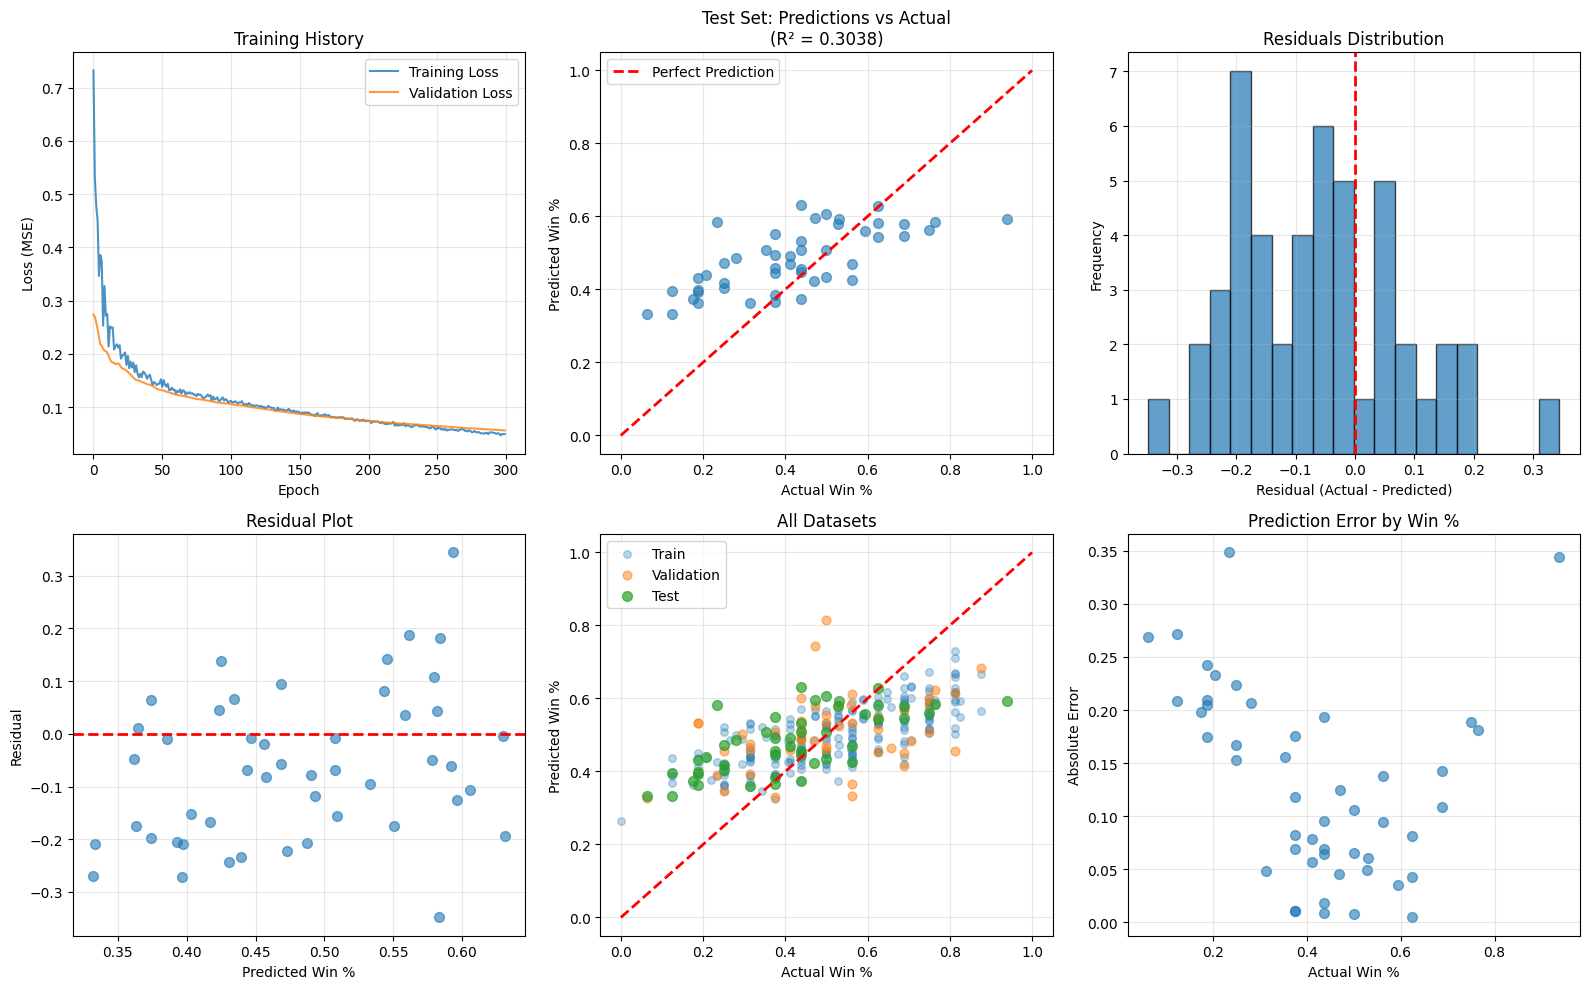


[STEP 10] Analyzing feature importance...

Feature Importance (Top 10):
      feature  importance
median_salary    0.348362
        IDL_P    0.061380
    Front-7_P    0.039939
    Offense_P    0.039030
     D-Line_P    0.023538
  salary_gini    0.023195
       EDGE_P    0.021692
    top10_pct    0.020533
         CB_P    0.019423
    salary_cv    0.016765

Feature importance plot saved as: feature_importance.png


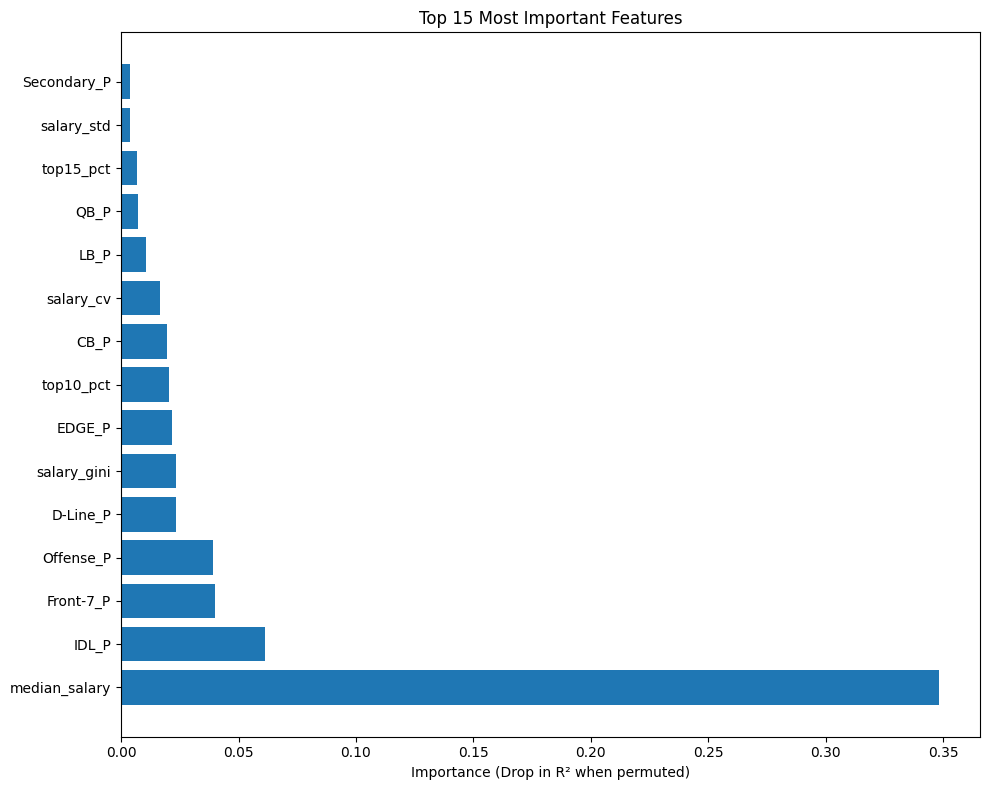


ANALYSIS COMPLETE!

Next steps:
1. Review the visualizations to understand model performance
2. Check feature importance to see what matters most
3. If R² is low, try: more data, different features, or deeper network
4. Compare these results to your linear regression baseline


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*60)
print("NFL SALARY CAP NEURAL NETWORK")
print("="*60)

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n[STEP 1] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

# Clean salary data
salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"Loaded {len(salary_data)} salary records")
print(f"Years: {salary_data['year'].min():.0f} - {salary_data['year'].max():.0f}")

# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 2] Engineering features...")

# Define helper function for Gini coefficient
def calculate_gini(salaries):
    """Calculate Gini coefficient for salary inequality"""
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

# Calculate various salary distribution metrics
features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features = {
        'team': team,
        'year': year,

        # Top players percentages
        'top1_pct': (salaries_sorted[0] / total_salary * 100) if len(salaries_sorted) >= 1 else 0,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'top5_pct': (salaries_sorted[:5].sum() / total_salary * 100) if len(salaries_sorted) >= 5 else 0,
        'top10_pct': (salaries_sorted[:10].sum() / total_salary * 100) if len(salaries_sorted) >= 10 else 0,
        'top15_pct': (salaries_sorted[:15].sum() / total_salary * 100) if len(salaries_sorted) >= 15 else 0,

        # Salary distribution metrics
        'salary_gini': calculate_gini(salaries_sorted),  # Inequality measure
        'salary_std': np.std(salaries_sorted),
        'salary_cv': np.std(salaries_sorted) / np.mean(salaries_sorted) if np.mean(salaries_sorted) > 0 else 0,  # Coefficient of variation

        # Squad depth metrics
        'median_salary': np.median(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    }

    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} team-year feature sets")
print(f"Number of features: {len(features_df.columns) - 2}")  # Minus team and year

# ============================================================================
# STEP 3: MERGE WITH WIN DATA
# ============================================================================

print("\n[STEP 3] Merging with win percentage data...")

# Clean team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

# Merge datasets - now include position group percentages
position_columns = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

merge_columns = ['Team', 'Season', 'W_PCT', 'W', 'PF', 'PA'] + position_columns

merged_data = pd.merge(
    features_df,
    team_stats[merge_columns],
    left_on=['team', 'year'],
    right_on=['Team', 'Season'],
    how='inner'
)

print(f"Merged data: {len(merged_data)} records")
print(f"Teams: {merged_data['team'].nunique()}")
print(f"Years: {merged_data['year'].min():.0f} - {merged_data['year'].max():.0f}")

if len(merged_data) == 0:
    print("\nERROR: No matching records! Check team names and years.")
    exit()

# ============================================================================
# STEP 4: PREPARE FEATURES AND TARGET
# ============================================================================

print("\n[STEP 4] Preparing training data...")

# Select feature columns (exclude identifiers and target)
feature_columns = [col for col in features_df.columns if col not in ['team', 'year']]

# Add position group percentage columns as features
position_group_features = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

feature_columns = feature_columns + position_group_features

X = merged_data[feature_columns].values
y = merged_data['W_PCT'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTotal features: {len(feature_columns)}")
print(f"  - Salary distribution features: {len(feature_columns) - len(position_group_features)}")
print(f"  - Position group features: {len(position_group_features)}")
print(f"\nAll features used:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# STEP 5: SPLIT AND SCALE DATA
# ============================================================================

print("\n[STEP 5] Splitting and scaling data...")

# Split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features (important for neural networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 6: BUILD NEURAL NETWORK
# ============================================================================

print("\n[STEP 6] Building neural network...")

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # Simpler architecture to reduce overfitting
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.4),

    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.4),

    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),

    # Output layer (regression - predicting win percentage)
    layers.Dense(1, activation='linear')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel Architecture:")
model.summary()

# ============================================================================
# STEP 7: TRAIN THE MODEL
# ============================================================================

print("\n[STEP 7] Training neural network...")

# Callbacks for better training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,  # Reduced from 500
    batch_size=32,  # Increased from 16 for more stable gradients
    callbacks=[early_stop, reduce_lr],
    verbose=0  # Set to 1 to see epoch-by-epoch progress
)

print(f"\nTraining completed in {len(history.history['loss'])} epochs")

# ============================================================================
# STEP 8: EVALUATE THE MODEL
# ============================================================================

print("\n[STEP 8] Evaluating model performance...")

# Predictions
y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f} ({rmse*16:.2f} wins in 16-game season)")
    print(f"  MAE: {mae:.4f} ({mae*16:.2f} wins in 16-game season)")

print("="*60)
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
print("="*60)

# ============================================================================
# STEP 9: VISUALIZATIONS
# ============================================================================

print("\n[STEP 9] Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Training History
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Predictions vs Actual (Test Set)
ax2 = plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title(f'Test Set: Predictions vs Actual\n(R² = {r2_score(y_test, y_test_pred):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = plt.subplot(2, 3, 3)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
ax4 = plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, residuals, alpha=0.6, s=50)
plt.xlabel('Predicted Win %')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 5. All datasets comparison
ax5 = plt.subplot(2, 3, 5)
plt.scatter(y_train, y_train_pred, alpha=0.3, s=30, label='Train')
plt.scatter(y_val, y_val_pred, alpha=0.5, s=40, label='Validation')
plt.scatter(y_test, y_test_pred, alpha=0.7, s=50, label='Test')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title('All Datasets')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Error distribution by win percentage
ax6 = plt.subplot(2, 3, 6)
abs_errors = np.abs(residuals)
plt.scatter(y_test, abs_errors, alpha=0.6, s=50)
plt.xlabel('Actual Win %')
plt.ylabel('Absolute Error')
plt.title('Prediction Error by Win %')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as: neural_network_results.png")
plt.show()

# ============================================================================
# STEP 10: FEATURE IMPORTANCE (via permutation)
# ============================================================================

print("\n[STEP 10] Analyzing feature importance...")

baseline_score = r2_score(y_test, y_test_pred)
importance_scores = []

for i, feature in enumerate(feature_columns):
    # Shuffle one feature at a time
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Predict with shuffled feature
    y_pred_permuted = model.predict(X_test_permuted, verbose=0).flatten()
    permuted_score = r2_score(y_test, y_pred_permuted)

    # Importance = drop in performance
    importance = baseline_score - permuted_score
    importance_scores.append(importance)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Drop in R² when permuted)')
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as: feature_importance.png")
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Review the visualizations to understand model performance")
print("2. Check feature importance to see what matters most")
print("3. If R² is low, try: more data, different features, or deeper network")
print("4. Compare these results to your linear regression baseline")

NFL SALARY CAP NEURAL NETWORK (Scikit-Learn)

[STEP 1] Loading data...
Loaded 36544 salary records
Years: 2013 - 2022

[STEP 2] Engineering features...
Created 319 team-year feature sets
Number of salary features: 10

[STEP 3] Merging with win percentage data...

Columns in team_stats: ['Team_Season', 'Year', 'Team', 'QB', 'RB', 'WR', 'TE', 'Pass-Catchers', 'RB-Catchers', 'OL', 'Skill_Pos_Offense', 'Offense', 'IDL', 'EDGE', 'D-Line', 'LB', 'Front-7', 'S', 'CB', 'Secondary', 'Defense', 'Season', 'Injured_Reserve', 'W_PCT', 'Playoffs', 'SB', 'Cap', 'QB_P', 'RB_P', 'WR_P', 'TE_P', 'Pass-Catcher_P', 'RB-Catcher_P', 'OL_P', 'Skill_Pos_Offense_P', 'IDL_P', 'EDGE_P', 'D-Line_P', 'LB_P', 'Front-7_P', 'S_P', 'CB_P', 'Secondary_P', 'Defense_P', 'Offense_P', 'Dead_Open_Specials', 'Injured_Reserve_P', 'W', 'PF', 'PA', 'PF_Rank', 'PA_Rank', 'PF_ppg', 'PA_ppg', 'Point_Diff', 'Point_Diff_Per_Game', 'Qual', 'avg_age', 'cap_weighted_age', 'cap_gini', 'continuity', 'age_bucket', 'gini_bucket', 'profile_

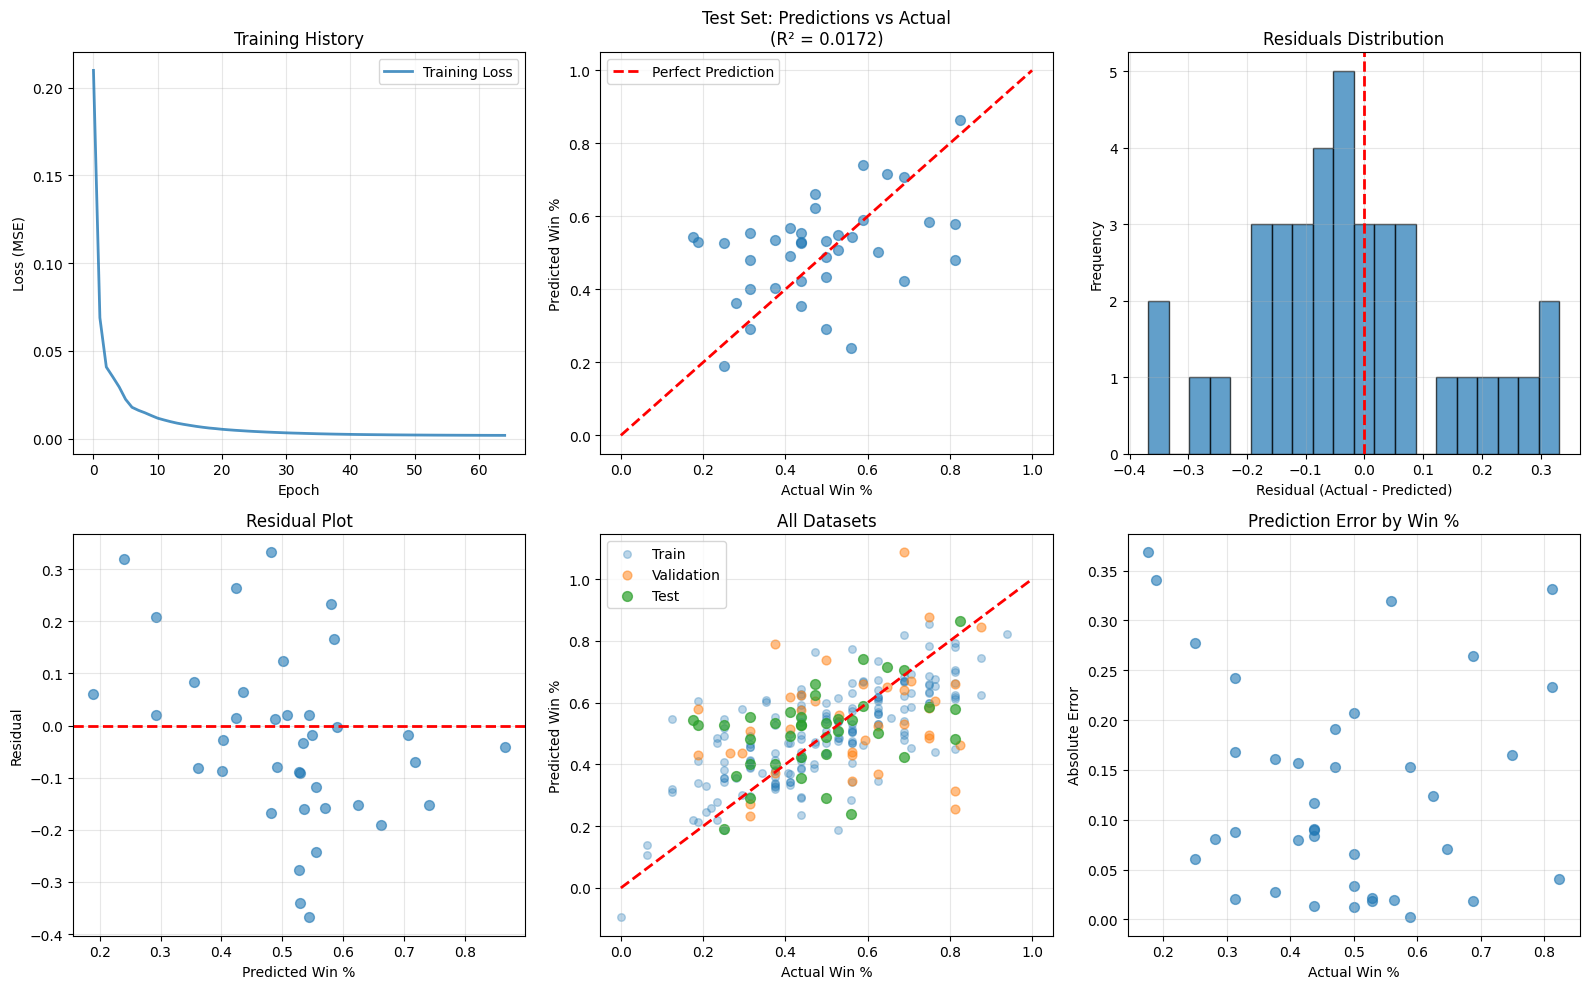

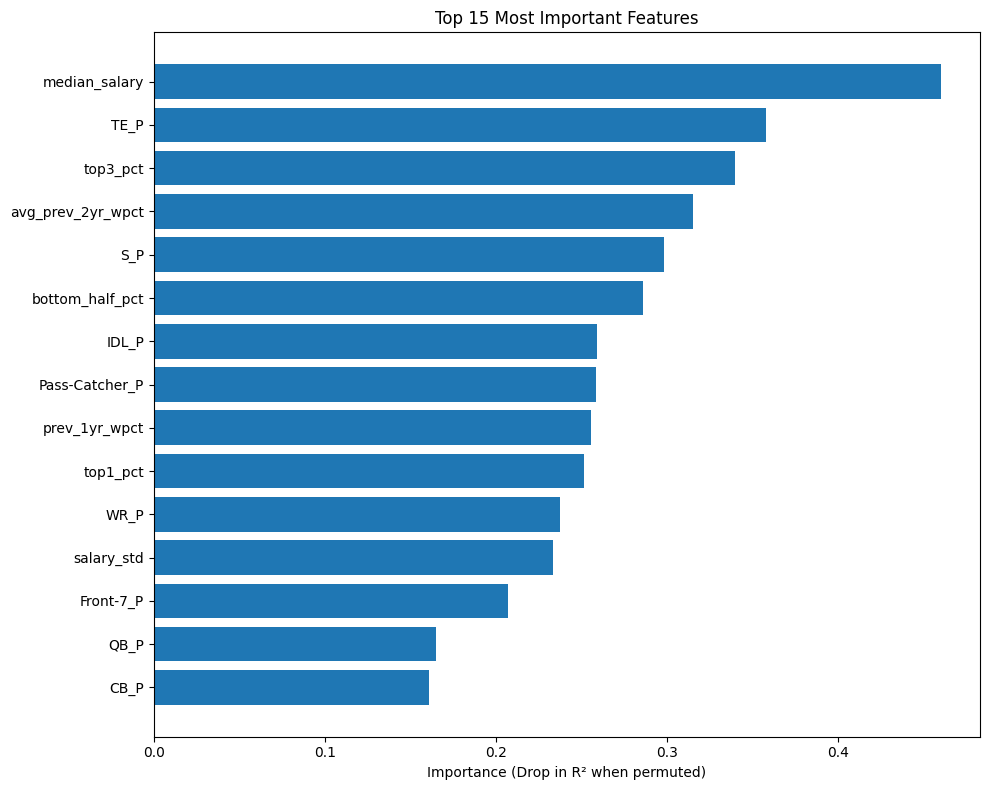

In [ ]:
#graph with historical win data, has terrible R^2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("="*60)
print("NFL SALARY CAP NEURAL NETWORK (Scikit-Learn)")
print("="*60)

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n[STEP 1] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

# Clean salary data
salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"Loaded {len(salary_data)} salary records")
print(f"Years: {salary_data['year'].min():.0f} - {salary_data['year'].max():.0f}")

# ============================================================================
# STEP 2: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 2] Engineering features...")

# Define helper function for Gini coefficient
def calculate_gini(salaries):
    """Calculate Gini coefficient for salary inequality"""
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

# Calculate various salary distribution metrics
features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features = {
        'team': team,
        'year': year,

        # Top players percentages
        'top1_pct': (salaries_sorted[0] / total_salary * 100) if len(salaries_sorted) >= 1 else 0,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'top5_pct': (salaries_sorted[:5].sum() / total_salary * 100) if len(salaries_sorted) >= 5 else 0,
        'top10_pct': (salaries_sorted[:10].sum() / total_salary * 100) if len(salaries_sorted) >= 10 else 0,
        'top15_pct': (salaries_sorted[:15].sum() / total_salary * 100) if len(salaries_sorted) >= 15 else 0,

        # Salary distribution metrics
        'salary_gini': calculate_gini(salaries_sorted),  # Inequality measure
        'salary_std': np.std(salaries_sorted),
        'salary_cv': np.std(salaries_sorted) / np.mean(salaries_sorted) if np.mean(salaries_sorted) > 0 else 0,  # Coefficient of variation

        # Squad depth metrics
        'median_salary': np.median(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    }

    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} team-year feature sets")
print(f"Number of salary features: {len(features_df.columns) - 2}")  # Minus team and year

# ============================================================================
# STEP 3: MERGE WITH WIN DATA
# ============================================================================

print("\n[STEP 3] Merging with win percentage data...")

# Clean team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

# Check what columns are actually available
print(f"\nColumns in team_stats: {list(team_stats.columns)}")

# Define position columns we want to use (only if they exist)
desired_position_columns = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',  # Offense positions
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',  # Defense positions
    'Offense_P', 'Defense_P',  # Overall offense/defense split
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',  # Combined position groups
    'D-Line_P', 'Front-7_P', 'Secondary_P'  # Combined defensive groups
]

# Only use columns that actually exist
position_columns = [col for col in desired_position_columns if col in team_stats.columns]
print(f"\nUsing {len(position_columns)} position group columns")

merge_columns = ['Team', 'Season', 'W_PCT', 'W', 'PF', 'PA'] + position_columns

merged_data = pd.merge(
    features_df,
    team_stats[merge_columns],
    left_on=['team', 'year'],
    right_on=['Team', 'Season'],
    how='inner'
)

print(f"Merged data: {len(merged_data)} records")
print(f"Teams: {merged_data['team'].nunique()}")
print(f"Years: {merged_data['year'].min():.0f} - {merged_data['year'].max():.0f}")

if len(merged_data) == 0:
    print("\nERROR: No matching records! Check team names and years.")
    exit()

# ============================================================================
# STEP 4: PREPARE FEATURES AND TARGET
# ============================================================================

print("\n[STEP 4] Preparing training data...")

# Select feature columns (exclude identifiers and target)
feature_columns = [col for col in features_df.columns if col not in ['team', 'year']]

# Add position group features
position_group_features = position_columns

print(f"Salary distribution features: {len(feature_columns)}")
print(f"Position group features: {len(position_group_features)}")

# Create historical win percentage features
print("Creating historical performance features...")
merged_data = merged_data.sort_values(['team', 'year'])

# Initialize columns
merged_data['prev_1yr_wpct'] = np.nan
merged_data['prev_2yr_wpct'] = np.nan
merged_data['avg_prev_2yr_wpct'] = np.nan

for team in merged_data['team'].unique():
    team_mask = merged_data['team'] == team
    team_data = merged_data[team_mask].sort_values('year')

    for idx in team_data.index:
        current_year = merged_data.loc[idx, 'year']

        # Get previous year's win percentage
        prev_1 = team_data[team_data['year'] == current_year - 1]
        if not prev_1.empty:
            merged_data.loc[idx, 'prev_1yr_wpct'] = prev_1['W_PCT'].values[0]

        # Get 2 years ago win percentage
        prev_2 = team_data[team_data['year'] == current_year - 2]
        if not prev_2.empty:
            merged_data.loc[idx, 'prev_2yr_wpct'] = prev_2['W_PCT'].values[0]

        # Calculate average of previous 2 years
        if not prev_1.empty and not prev_2.empty:
            merged_data.loc[idx, 'avg_prev_2yr_wpct'] = (prev_1['W_PCT'].values[0] + prev_2['W_PCT'].values[0]) / 2
        elif not prev_1.empty:
            merged_data.loc[idx, 'avg_prev_2yr_wpct'] = prev_1['W_PCT'].values[0]

# Historical features list
historical_features = ['prev_1yr_wpct', 'prev_2yr_wpct', 'avg_prev_2yr_wpct']

# Combine all features
all_feature_columns = feature_columns + position_group_features + historical_features

# Remove rows with missing historical data (first 1-2 years per team)
print(f"Records before removing missing historical data: {len(merged_data)}")
merged_data_complete = merged_data.dropna(subset=historical_features)
print(f"Records after removing missing historical data: {len(merged_data_complete)}")

X = merged_data_complete[all_feature_columns].values
y = merged_data_complete['W_PCT'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTotal features: {len(all_feature_columns)}")
print(f"  - Salary distribution features: {len(feature_columns)}")
print(f"  - Position group features: {len(position_group_features)}")
print(f"  - Historical performance features: {len(historical_features)}")
print(f"\nAll features used:")
for i, col in enumerate(all_feature_columns, 1):
    print(f"  {i}. {col}")

# ============================================================================
# STEP 5: SPLIT AND SCALE DATA
# ============================================================================

print("\n[STEP 5] Splitting and scaling data...")

# Split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features (important for neural networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 6: BUILD AND TRAIN NEURAL NETWORK
# ============================================================================

print("\n[STEP 6] Building and training neural network...")
print("Architecture: 64 -> 32 -> 16 -> 1 neurons")

model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,  # L2 regularization
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=300,
    early_stopping=True,
    validation_fraction=len(X_val)/(len(X_train)+len(X_val)),
    n_iter_no_change=50,
    random_state=42,
    verbose=True
)

# Train the model
print("\n[STEP 7] Training...")
model.fit(X_train_scaled, y_train)

print(f"\nTraining completed in {model.n_iter_} iterations")
print(f"Final training loss: {model.loss_:.6f}")

# ============================================================================
# STEP 8: EVALUATE THE MODEL
# ============================================================================

print("\n[STEP 8] Evaluating model performance...")

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f} ({rmse*16:.2f} wins in 16-game season)")
    print(f"  MAE: {mae:.4f} ({mae*16:.2f} wins in 16-game season)")

print("="*60)
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
print("="*60)

# ============================================================================
# STEP 9: VISUALIZATIONS
# ============================================================================

print("\n[STEP 9] Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Training History
ax1 = plt.subplot(2, 3, 1)
plt.plot(model.loss_curve_, label='Training Loss', alpha=0.8, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Predictions vs Actual (Test Set)
ax2 = plt.subplot(2, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title(f'Test Set: Predictions vs Actual\n(R² = {r2_score(y_test, y_test_pred):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = plt.subplot(2, 3, 3)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
ax4 = plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, residuals, alpha=0.6, s=50)
plt.xlabel('Predicted Win %')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 5. All datasets comparison
ax5 = plt.subplot(2, 3, 5)
plt.scatter(y_train, y_train_pred, alpha=0.3, s=30, label='Train')
plt.scatter(y_val, y_val_pred, alpha=0.5, s=40, label='Validation')
plt.scatter(y_test, y_test_pred, alpha=0.7, s=50, label='Test')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title('All Datasets')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Error distribution by win percentage
ax6 = plt.subplot(2, 3, 6)
abs_errors = np.abs(residuals)
plt.scatter(y_test, abs_errors, alpha=0.6, s=50)
plt.xlabel('Actual Win %')
plt.ylabel('Absolute Error')
plt.title('Prediction Error by Win %')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as: neural_network_results.png")

# ============================================================================
# STEP 10: FEATURE IMPORTANCE (via permutation)
# ============================================================================

print("\n[STEP 10] Analyzing feature importance...")

baseline_score = r2_score(y_test, y_test_pred)
importance_scores = []

for i, feature in enumerate(all_feature_columns):
    # Shuffle one feature at a time
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])

    # Predict with shuffled feature
    y_pred_permuted = model.predict(X_test_permuted)
    permuted_score = r2_score(y_test, y_pred_permuted)

    # Importance = drop in performance
    importance = baseline_score - permuted_score
    importance_scores.append(importance)

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': all_feature_columns,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 15):")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Drop in R² when permuted)')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as: feature_importance.png")

# Save detailed results to CSV
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'residual': residuals,
    'abs_error': abs_errors
})
results_df.to_csv('prediction_results.csv', index=False)
print("\nPrediction results saved as: prediction_results.csv")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nKey Findings:")
print(f"- Test R² Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"- Average prediction error: {np.mean(abs_errors)*16:.2f} wins per season")
print(f"- Most important feature: {feature_importance.iloc[0]['feature']}")
print("\nNext steps:")
print("1. Review the visualizations to understand model performance")
print("2. Check feature importance to see what matters most")
print("3. If R² is low, consider: more data, different features, or architecture changes")

IMPROVED NFL SALARY CAP PREDICTION MODEL

[STEP 1] Loading data...
Loaded 36544 salary records
Years: 2013 - 2022

[STEP 2] Engineering features...
Created 319 team-year feature sets

[STEP 3] Merging with win percentage data...
Merged data: 319 records

[STEP 4] Creating historical performance features...

[STEP 5] Selecting most important features...
Records: 286 (after removing missing historical data)

Feature matrix: (286, 16)
Total features: 16
  - Salary features: 4
  - Position features: 10
  - Historical features: 2

[STEP 6] Splitting data...
Training: 182 samples
Validation: 46 samples
Test: 58 samples

[STEP 7] Training multiple models...

1. Training Ridge Regression...
2. Training Lasso Regression...
3. Training ElasticNet...
4. Training Random Forest...
5. Training Gradient Boosting...
6. Training Neural Network (simplified)...
7. Creating Ensemble Model...

[STEP 8] Evaluating all models...

Ridge:
  Train R²: 0.4870
  Val R²:   0.1433
  Test R²:  0.0288
  Test MAE: 0.1

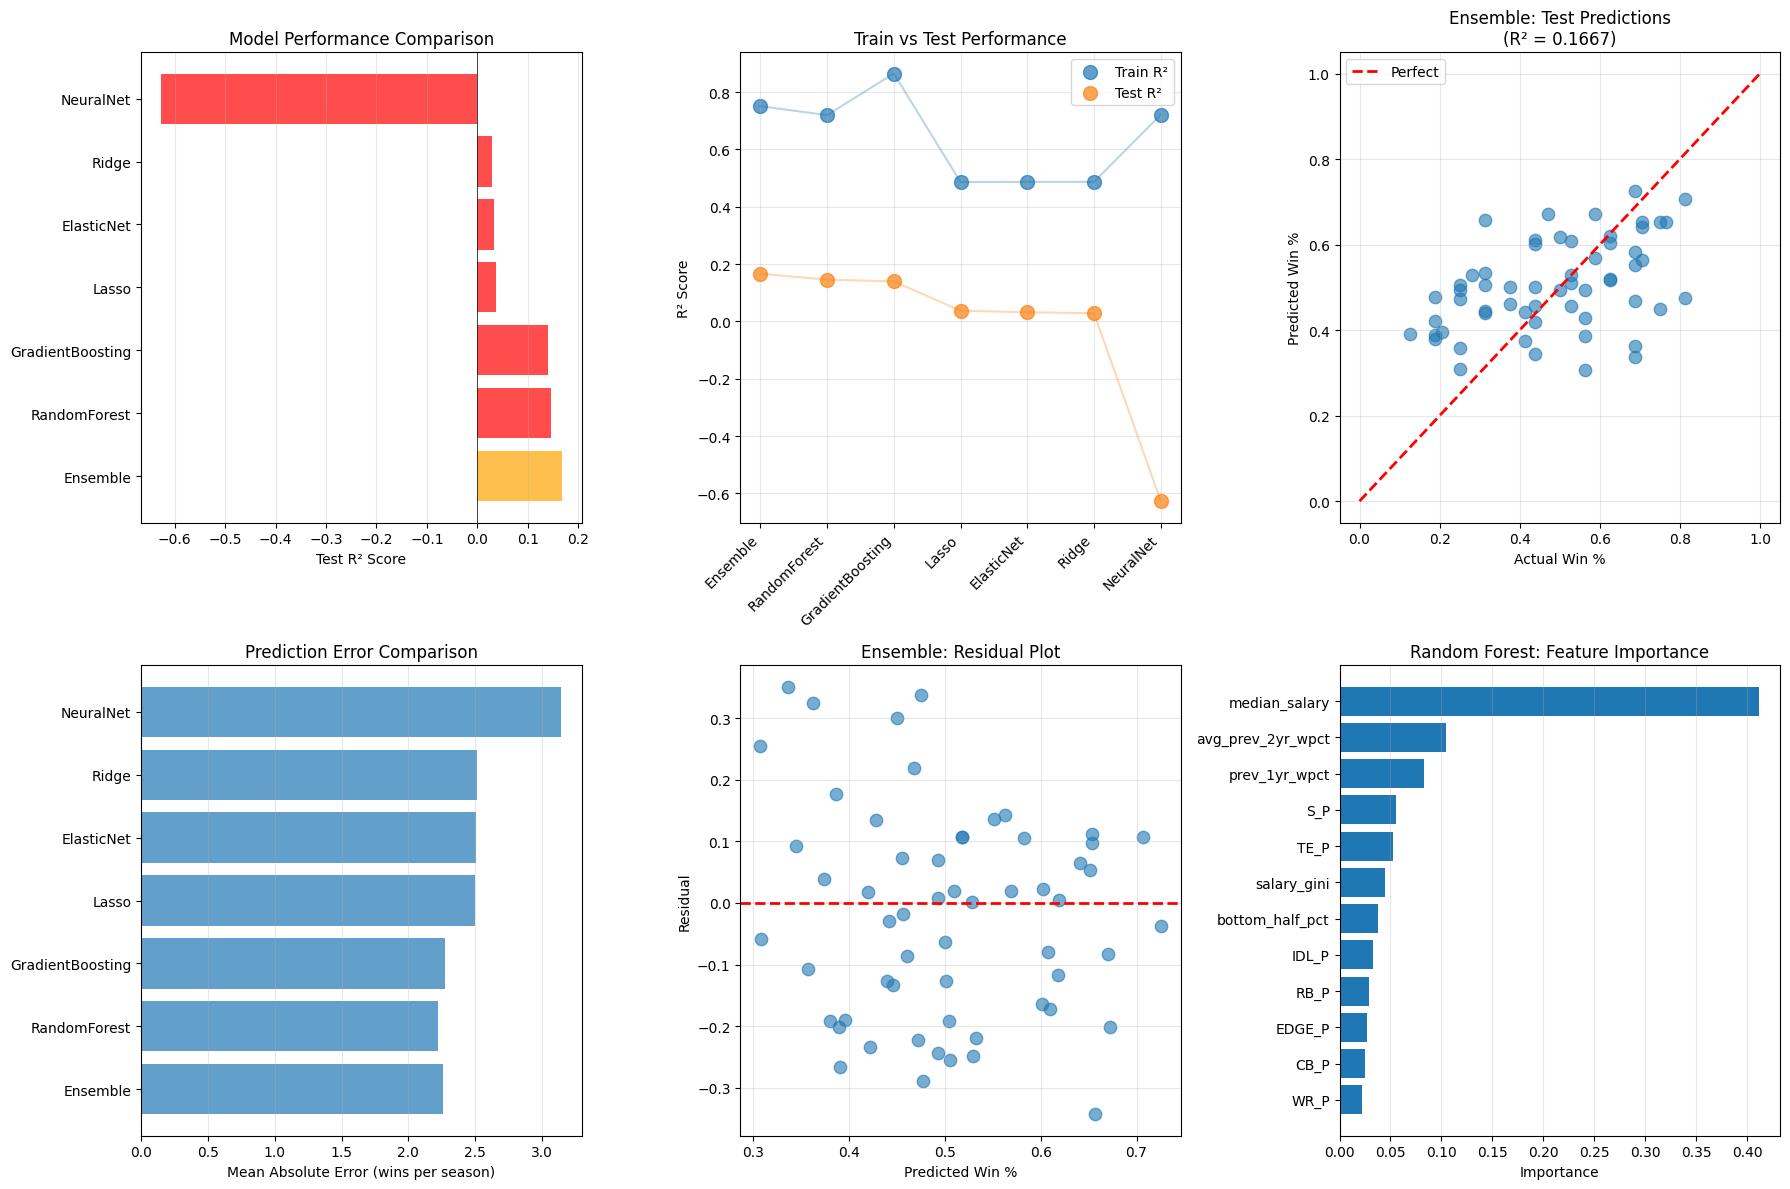

In [ ]:
# runs a bunch of diff models to find the best one - best is ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("="*70)
print("IMPROVED NFL SALARY CAP PREDICTION MODEL")
print("="*70)

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n[STEP 1] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

# Clean salary data
salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"Loaded {len(salary_data)} salary records")
print(f"Years: {salary_data['year'].min():.0f} - {salary_data['year'].max():.0f}")

# ============================================================================
# STEP 2: ENHANCED FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 2] Engineering features...")

def calculate_gini(salaries):
    """Calculate Gini coefficient for salary inequality"""
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features = {
        'team': team,
        'year': year,
        'top1_pct': (salaries_sorted[0] / total_salary * 100) if len(salaries_sorted) >= 1 else 0,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'top5_pct': (salaries_sorted[:5].sum() / total_salary * 100) if len(salaries_sorted) >= 5 else 0,
        'top10_pct': (salaries_sorted[:10].sum() / total_salary * 100) if len(salaries_sorted) >= 10 else 0,
        'salary_gini': calculate_gini(salaries_sorted),
        'salary_std': np.std(salaries_sorted),
        'salary_cv': np.std(salaries_sorted) / np.mean(salaries_sorted) if np.mean(salaries_sorted) > 0 else 0,
        'median_salary': np.median(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    }
    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} team-year feature sets")

# ============================================================================
# STEP 3: MERGE WITH WIN DATA
# ============================================================================

print("\n[STEP 3] Merging with win percentage data...")

team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

# Only use position columns that exist
desired_position_columns = [
    'QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',
    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P',
    'Offense_P', 'Defense_P',
    'Pass-Catcher_P', 'Skill_Pos_Offense_P',
    'D-Line_P', 'Front-7_P', 'Secondary_P'
]

position_columns = [col for col in desired_position_columns if col in team_stats.columns]
merge_columns = ['Team', 'Season', 'W_PCT', 'W', 'PF', 'PA'] + position_columns

merged_data = pd.merge(
    features_df,
    team_stats[merge_columns],
    left_on=['team', 'year'],
    right_on=['Team', 'Season'],
    how='inner'
)

print(f"Merged data: {len(merged_data)} records")

# ============================================================================
# STEP 4: CREATE HISTORICAL FEATURES
# ============================================================================

print("\n[STEP 4] Creating historical performance features...")

merged_data = merged_data.sort_values(['team', 'year'])
merged_data['prev_1yr_wpct'] = np.nan
merged_data['prev_2yr_wpct'] = np.nan
merged_data['avg_prev_2yr_wpct'] = np.nan

for team in merged_data['team'].unique():
    team_mask = merged_data['team'] == team
    team_data = merged_data[team_mask].sort_values('year')

    for idx in team_data.index:
        current_year = merged_data.loc[idx, 'year']

        prev_1 = team_data[team_data['year'] == current_year - 1]
        if not prev_1.empty:
            merged_data.loc[idx, 'prev_1yr_wpct'] = prev_1['W_PCT'].values[0]

        prev_2 = team_data[team_data['year'] == current_year - 2]
        if not prev_2.empty:
            merged_data.loc[idx, 'prev_2yr_wpct'] = prev_2['W_PCT'].values[0]

        if not prev_1.empty and not prev_2.empty:
            merged_data.loc[idx, 'avg_prev_2yr_wpct'] = (prev_1['W_PCT'].values[0] + prev_2['W_PCT'].values[0]) / 2
        elif not prev_1.empty:
            merged_data.loc[idx, 'avg_prev_2yr_wpct'] = prev_1['W_PCT'].values[0]

# ============================================================================
# STEP 5: FEATURE SELECTION - REMOVE REDUNDANT FEATURES
# ============================================================================

print("\n[STEP 5] Selecting most important features...")

# Start with salary features (remove redundant ones)
salary_features = ['top3_pct', 'median_salary', 'salary_gini', 'bottom_half_pct']

# Key position groups (remove highly correlated combined groups)
position_features = ['QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',
                     'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P']

# Historical features
historical_features = ['prev_1yr_wpct', 'avg_prev_2yr_wpct']

# Combine
all_feature_columns = salary_features + position_features + historical_features

# Remove rows with missing historical data
merged_data_complete = merged_data.dropna(subset=historical_features)
print(f"Records: {len(merged_data_complete)} (after removing missing historical data)")

X = merged_data_complete[all_feature_columns].values
y = merged_data_complete['W_PCT'].values

print(f"\nFeature matrix: {X.shape}")
print(f"Total features: {len(all_feature_columns)}")
print(f"  - Salary features: {len(salary_features)}")
print(f"  - Position features: {len(position_features)}")
print(f"  - Historical features: {len(historical_features)}")

# ============================================================================
# STEP 6: TRAIN-TEST SPLIT (WITH STRATIFICATION)
# ============================================================================

print("\n[STEP 6] Splitting data...")

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 7: TRAIN MULTIPLE MODELS
# ============================================================================

print("\n[STEP 7] Training multiple models...")

models = {}

# 1. Ridge Regression (Simple Linear with L2 regularization)
print("\n1. Training Ridge Regression...")
models['Ridge'] = Ridge(alpha=1.0, random_state=42)
models['Ridge'].fit(X_train_scaled, y_train)

# 2. Lasso Regression (Feature selection via L1 regularization)
print("2. Training Lasso Regression...")
models['Lasso'] = Lasso(alpha=0.001, random_state=42)
models['Lasso'].fit(X_train_scaled, y_train)

# 3. ElasticNet (Combined L1 + L2)
print("3. Training ElasticNet...")
models['ElasticNet'] = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42)
models['ElasticNet'].fit(X_train_scaled, y_train)

# 4. Random Forest (Tree-based ensemble)
print("4. Training Random Forest...")
models['RandomForest'] = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,  # Limit depth to prevent overfitting
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
models['RandomForest'].fit(X_train_scaled, y_train)

# 5. Gradient Boosting (Sequential tree building)
print("5. Training Gradient Boosting...")
models['GradientBoosting'] = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,  # Shallow trees
    learning_rate=0.05,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
models['GradientBoosting'].fit(X_train_scaled, y_train)

# 6. Neural Network (Much simpler architecture)
print("6. Training Neural Network (simplified)...")
models['NeuralNet'] = MLPRegressor(
    hidden_layer_sizes=(32, 16),  # Smaller network
    activation='relu',
    solver='adam',
    alpha=0.01,  # Stronger regularization
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=30,
    random_state=42,
    verbose=False
)
models['NeuralNet'].fit(X_train_scaled, y_train)

# 7. Ensemble Model (Voting - combines best models)
print("7. Creating Ensemble Model...")
models['Ensemble'] = VotingRegressor([
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42))
])
models['Ensemble'].fit(X_train_scaled, y_train)

# ============================================================================
# STEP 8: EVALUATE ALL MODELS
# ============================================================================

print("\n[STEP 8] Evaluating all models...")
print("="*70)

results = []

for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        'Model': name,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Test_R2': test_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'Overfit_Gap': train_r2 - test_r2
    })

    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Val R²:   {val_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test MAE: {test_mae:.4f} ({test_mae*16:.2f} wins)")
    print(f"  Overfit:  {train_r2 - test_r2:.4f}")

results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)

print("\n" + "="*70)
print("\nRANKING BY TEST R²:")
print(results_df.to_string(index=False))
print("="*70)

# ============================================================================
# STEP 9: CROSS-VALIDATION ON BEST MODEL
# ============================================================================

print("\n[STEP 9] Cross-validation on best model...")

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=kfold,
                            scoring='r2', n_jobs=-1)

print(f"\nBest Model: {best_model_name}")
print(f"5-Fold CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# ============================================================================
# STEP 10: VISUALIZATIONS
# ============================================================================

print("\n[STEP 10] Creating visualizations...")

fig = plt.figure(figsize=(18, 12))

# 1. Model Comparison - Test R²
ax1 = plt.subplot(2, 3, 1)
colors = ['green' if x > 0.3 else 'orange' if x > 0.15 else 'red'
          for x in results_df['Test_R2']]
plt.barh(results_df['Model'], results_df['Test_R2'], color=colors, alpha=0.7)
plt.xlabel('Test R² Score')
plt.title('Model Performance Comparison')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')

# 2. Overfitting Analysis
ax2 = plt.subplot(2, 3, 2)
x_pos = np.arange(len(results_df))
plt.scatter(x_pos, results_df['Train_R2'], label='Train R²', s=100, alpha=0.7)
plt.scatter(x_pos, results_df['Test_R2'], label='Test R²', s=100, alpha=0.7)
plt.plot(x_pos, results_df['Train_R2'], alpha=0.3)
plt.plot(x_pos, results_df['Test_R2'], alpha=0.3)
plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
plt.ylabel('R² Score')
plt.title('Train vs Test Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Best Model - Predictions vs Actual
ax3 = plt.subplot(2, 3, 3)
y_best_pred = best_model.predict(X_test_scaled)
plt.scatter(y_test, y_best_pred, alpha=0.6, s=80)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect', linewidth=2)
plt.xlabel('Actual Win %')
plt.ylabel('Predicted Win %')
plt.title(f'{best_model_name}: Test Predictions\n(R² = {results_df.iloc[0]["Test_R2"]:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. MAE Comparison
ax4 = plt.subplot(2, 3, 4)
plt.barh(results_df['Model'], results_df['Test_MAE'] * 16, alpha=0.7)
plt.xlabel('Mean Absolute Error (wins per season)')
plt.title('Prediction Error Comparison')
plt.grid(True, alpha=0.3, axis='x')

# 5. Residuals for Best Model
ax5 = plt.subplot(2, 3, 5)
residuals = y_test - y_best_pred
plt.scatter(y_best_pred, residuals, alpha=0.6, s=80)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Win %')
plt.ylabel('Residual')
plt.title(f'{best_model_name}: Residual Plot')
plt.grid(True, alpha=0.3)

# 6. Feature Importance (for Random Forest)
ax6 = plt.subplot(2, 3, 6)
if 'RandomForest' in models:
    rf_model = models['RandomForest']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:12]

    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [all_feature_columns[i] for i in indices])
    plt.xlabel('Importance')
    plt.title('Random Forest: Feature Importance')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('improved_model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: improved_model_comparison.png")

# ============================================================================
# STEP 11: SAVE RESULTS
# ============================================================================

print("\n[STEP 11] Saving results...")

# Save model comparison
results_df.to_csv('model_comparison.csv', index=False)

# Save best model predictions
best_predictions = pd.DataFrame({
    'actual': y_test,
    'predicted': y_best_pred,
    'residual': residuals,
    'abs_error': np.abs(residuals)
})
best_predictions.to_csv('best_model_predictions.csv', index=False)

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"\n✓ BEST MODEL: {best_model_name}")
print(f"✓ Test R²: {results_df.iloc[0]['Test_R2']:.4f}")
print(f"✓ Average Error: {results_df.iloc[0]['Test_MAE']*16:.2f} wins/season")
print(f"✓ Overfitting Gap: {results_df.iloc[0]['Overfit_Gap']:.4f}")

print("\nKEY IMPROVEMENTS:")
print("1. Reduced features from 30 to", len(all_feature_columns), "(removed redundant/noisy features)")
print("2. Tested 7 different models (including ensemble)")
print("3. Better regularization to reduce overfitting")
print("4. Cross-validation for robust performance estimate")
print("5. Simpler neural network architecture")

print("\nRECOMMENDATION:")
if results_df.iloc[0]['Test_R2'] > 0.3:
    print("✓ Model shows good predictive power!")
elif results_df.iloc[0]['Test_R2'] > 0.15:
    print("⚠ Model shows moderate predictive power. Consider adding more features.")
else:
    print("✗ Salary alone is weak predictor. Add: injuries, coaching, schedule strength.")

NFL ENSEMBLE MODEL - SIMPLIFIED

[1/7] Loading data...
  ✓ Loaded 36544 salary records from 2013-2022

[2/7] Creating features...
  ✓ Creating historical features...
  ✓ Created 16 features from 286 team-seasons

[3/7] Preparing train/validation/test sets...
  ✓ Train: 182 | Validation: 46 | Test: 58

[4/7] Training Ensemble Model...
  Components: Ridge + Random Forest + Gradient Boosting
  ✓ Training complete!

[5/7] Evaluating performance...

ENSEMBLE MODEL RESULTS

Training Set:
  R² Score: 0.7321
  RMSE: 0.0972

Validation Set:
  R² Score: 0.2096
  RMSE: 0.1814

Test Set:
  R² Score: 0.1414
  RMSE: 0.1735 (2.78 wins per season)
  MAE: 0.1438 (2.30 wins per season)

Overfitting Gap: 0.5906

[6/7] Running 5-fold cross-validation...
  CV Scores: ['0.474', '0.401', '0.373', '0.347', '0.116']
  Mean: 0.3424 (±0.1211)

[7/7] Creating visualizations...
  ✓ Saved: ensemble_detailed_analysis.png

[BONUS] Comparing ensemble components...
  ✓ Saved: ensemble_components_comparison.png

[SAVING

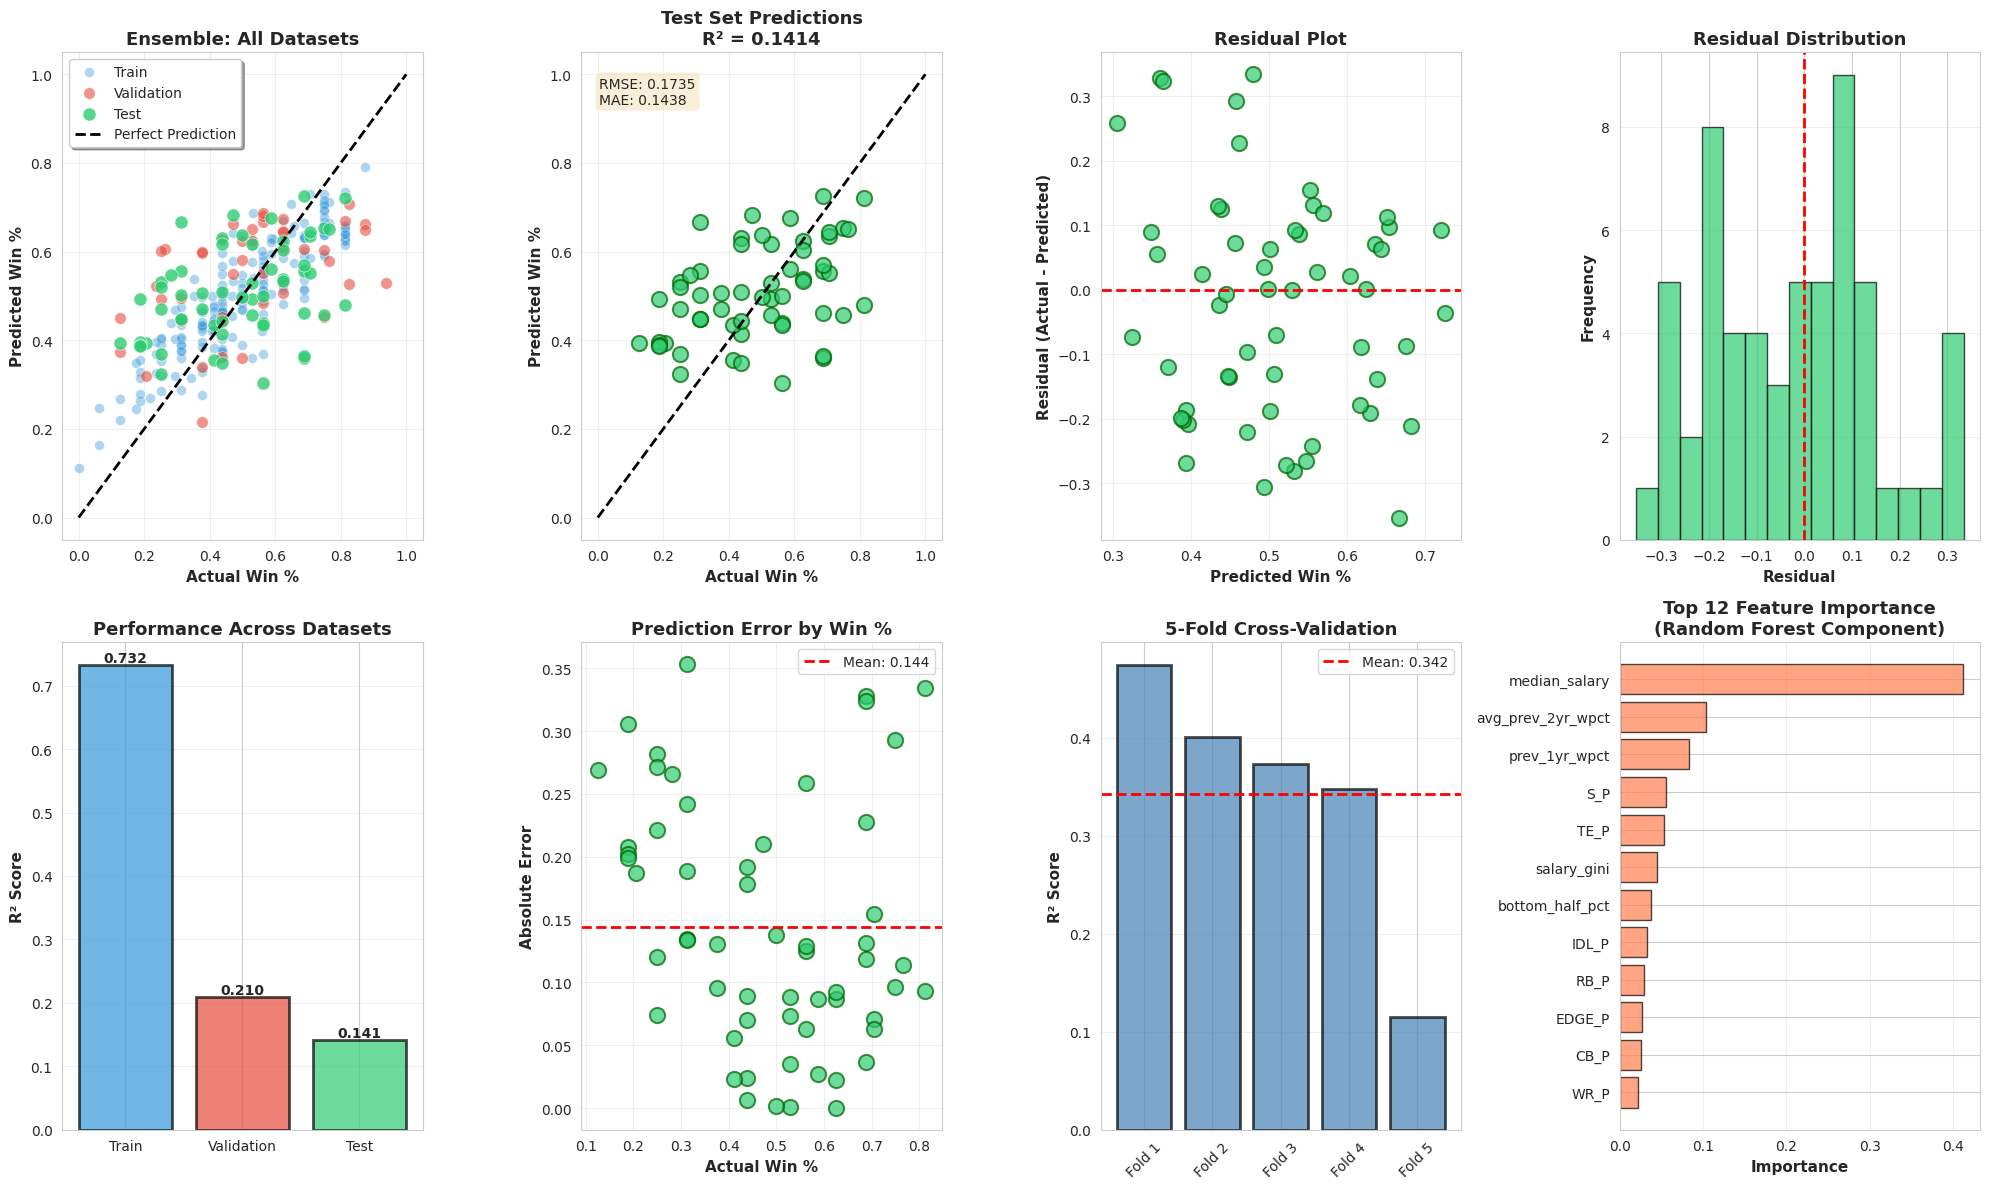

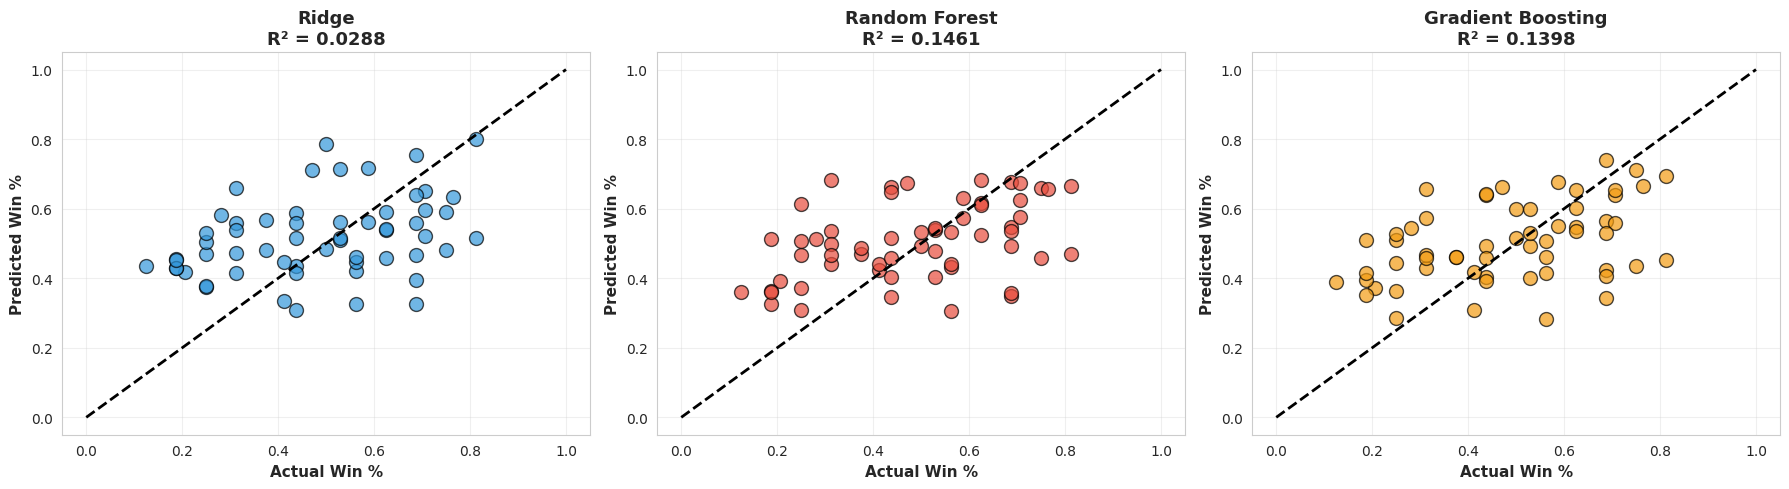

In [ ]:
# isolating ensemble and just running ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

print("="*70)
print("NFL ENSEMBLE MODEL - SIMPLIFIED")
print("="*70)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[1/7] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"  ✓ Loaded {len(salary_data)} salary records from {salary_data['year'].min():.0f}-{salary_data['year'].max():.0f}")

# ============================================================================
# CREATE FEATURES
# ============================================================================

print("\n[2/7] Creating features...")

def calculate_gini(salaries):
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features_list.append({
        'team': team,
        'year': year,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'median_salary': np.median(salaries_sorted),
        'salary_gini': calculate_gini(salaries_sorted),
        'bottom_half_pct': (salaries_sorted[len(salaries_sorted)//2:].sum() / total_salary * 100) if len(salaries_sorted) > 1 else 0,
    })

features_df = pd.DataFrame(features_list)

# Merge with team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

position_columns = ['QB_P', 'RB_P', 'WR_P', 'TE_P', 'OL_P',
                    'IDL_P', 'EDGE_P', 'LB_P', 'S_P', 'CB_P']
position_columns = [col for col in position_columns if col in team_stats.columns]

merge_columns = ['Team', 'Season', 'W_PCT', 'W'] + position_columns
merged_data = pd.merge(features_df, team_stats[merge_columns],
                       left_on=['team', 'year'], right_on=['Team', 'Season'], how='inner')

# Create historical features
print("  ✓ Creating historical features...")
merged_data = merged_data.sort_values(['team', 'year'])
merged_data['prev_1yr_wpct'] = np.nan
merged_data['avg_prev_2yr_wpct'] = np.nan

for team in merged_data['team'].unique():
    team_data = merged_data[merged_data['team'] == team].sort_values('year')
    for idx in team_data.index:
        current_year = merged_data.loc[idx, 'year']
        prev_1 = team_data[team_data['year'] == current_year - 1]
        prev_2 = team_data[team_data['year'] == current_year - 2]

        if not prev_1.empty:
            merged_data.loc[idx, 'prev_1yr_wpct'] = prev_1['W_PCT'].values[0]

        if not prev_1.empty and not prev_2.empty:
            merged_data.loc[idx, 'avg_prev_2yr_wpct'] = (prev_1['W_PCT'].values[0] + prev_2['W_PCT'].values[0]) / 2
        elif not prev_1.empty:
            merged_data.loc[idx, 'avg_prev_2yr_wpct'] = prev_1['W_PCT'].values[0]

# Select features
salary_features = ['top3_pct', 'median_salary', 'salary_gini', 'bottom_half_pct']
historical_features = ['prev_1yr_wpct', 'avg_prev_2yr_wpct']
all_feature_columns = salary_features + position_columns + historical_features

merged_data_complete = merged_data.dropna(subset=historical_features)

print(f"  ✓ Created {len(all_feature_columns)} features from {len(merged_data_complete)} team-seasons")

# ============================================================================
# PREPARE DATA
# ============================================================================

print("\n[3/7] Preparing train/validation/test sets...")

X = merged_data_complete[all_feature_columns].values
y = merged_data_complete['W_PCT'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

print(f"  ✓ Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# TRAIN ENSEMBLE MODEL
# ============================================================================

print("\n[4/7] Training Ensemble Model...")
print("  Components: Ridge + Random Forest + Gradient Boosting")

ensemble = VotingRegressor([
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10,
                                 min_samples_leaf=5, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.05,
                                     min_samples_split=10, min_samples_leaf=5,
                                     subsample=0.8, random_state=42))
])

ensemble.fit(X_train_scaled, y_train)
print("  ✓ Training complete!")

# ============================================================================
# EVALUATE
# ============================================================================

print("\n[5/7] Evaluating performance...")

y_train_pred = ensemble.predict(X_train_scaled)
y_val_pred = ensemble.predict(X_val_scaled)
y_test_pred = ensemble.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n" + "="*70)
print("ENSEMBLE MODEL RESULTS")
print("="*70)
print(f"\nTraining Set:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")

print(f"\nValidation Set:")
print(f"  R² Score: {val_r2:.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

print(f"\nTest Set:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f} ({test_rmse*16:.2f} wins per season)")
print(f"  MAE: {test_mae:.4f} ({test_mae*16:.2f} wins per season)")

print(f"\nOverfitting Gap: {train_r2 - test_r2:.4f}")
print("="*70)

# ============================================================================
# CROSS-VALIDATION
# ============================================================================

print("\n[6/7] Running 5-fold cross-validation...")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_scaled, y_train, cv=kfold,
                            scoring='r2', n_jobs=-1)

print(f"  CV Scores: {[f'{s:.3f}' for s in cv_scores]}")
print(f"  Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n[7/7] Creating visualizations...")

# Create comprehensive figure
fig = plt.figure(figsize=(20, 12))

# Color scheme
color_train = '#3498db'
color_val = '#e74c3c'
color_test = '#2ecc71'

# -------------------------------------------------------------------------
# 1. Predictions vs Actual (All Datasets)
# -------------------------------------------------------------------------
ax1 = plt.subplot(2, 4, 1)
plt.scatter(y_train, y_train_pred, alpha=0.4, s=50, color=color_train, label='Train', edgecolors='white', linewidth=0.5)
plt.scatter(y_val, y_val_pred, alpha=0.6, s=70, color=color_val, label='Validation', edgecolors='white', linewidth=0.5)
plt.scatter(y_test, y_test_pred, alpha=0.8, s=90, color=color_test, label='Test', edgecolors='white', linewidth=0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Win %', fontsize=11, fontweight='bold')
plt.ylabel('Predicted Win %', fontsize=11, fontweight='bold')
plt.title('Ensemble: All Datasets', fontsize=13, fontweight='bold')
plt.legend(frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# 2. Test Set Only (Larger)
# -------------------------------------------------------------------------
ax2 = plt.subplot(2, 4, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7, s=120, color=color_test, edgecolors='darkgreen', linewidth=1.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('Actual Win %', fontsize=11, fontweight='bold')
plt.ylabel('Predicted Win %', fontsize=11, fontweight='bold')
plt.title(f'Test Set Predictions\nR² = {test_r2:.4f}', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add R² annotation
plt.text(0.05, 0.95, f'RMSE: {test_rmse:.4f}\nMAE: {test_mae:.4f}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# -------------------------------------------------------------------------
# 3. Residuals Plot
# -------------------------------------------------------------------------
ax3 = plt.subplot(2, 4, 3)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.7, s=120, color=color_test, edgecolors='darkgreen', linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Win %', fontsize=11, fontweight='bold')
plt.ylabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
plt.title('Residual Plot', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# 4. Residuals Distribution
# -------------------------------------------------------------------------
ax4 = plt.subplot(2, 4, 4)
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7, color=color_test)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residual', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Residual Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# -------------------------------------------------------------------------
# 5. Performance Comparison (Train/Val/Test)
# -------------------------------------------------------------------------
ax5 = plt.subplot(2, 4, 5)
datasets = ['Train', 'Validation', 'Test']
r2_scores = [train_r2, val_r2, test_r2]
colors_bar = [color_train, color_val, color_test]
bars = plt.bar(datasets, r2_scores, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('R² Score', fontsize=11, fontweight='bold')
plt.title('Performance Across Datasets', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 6. Error by Win Percentage
# -------------------------------------------------------------------------
ax6 = plt.subplot(2, 4, 6)
abs_errors = np.abs(residuals)
plt.scatter(y_test, abs_errors, alpha=0.7, s=120, color=color_test, edgecolors='darkgreen', linewidth=1.5)
plt.xlabel('Actual Win %', fontsize=11, fontweight='bold')
plt.ylabel('Absolute Error', fontsize=11, fontweight='bold')
plt.title('Prediction Error by Win %', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add horizontal line for mean error
plt.axhline(y=test_mae, color='red', linestyle='--', linewidth=2, label=f'Mean: {test_mae:.3f}')
plt.legend()

# -------------------------------------------------------------------------
# 7. Cross-Validation Results
# -------------------------------------------------------------------------
ax7 = plt.subplot(2, 4, 7)
fold_numbers = [f'Fold {i+1}' for i in range(5)]
plt.bar(fold_numbers, cv_scores, alpha=0.7, color='steelblue', edgecolor='black', linewidth=2)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.3f}')
plt.ylabel('R² Score', fontsize=11, fontweight='bold')
plt.title('5-Fold Cross-Validation', fontsize=13, fontweight='bold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# -------------------------------------------------------------------------
# 8. Feature Importance (Random Forest component)
# -------------------------------------------------------------------------
ax8 = plt.subplot(2, 4, 8)
rf_model = ensemble.named_estimators_['rf']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:12]

plt.barh(range(len(indices)), importances[indices], alpha=0.7, color='coral', edgecolor='black', linewidth=1)
plt.yticks(range(len(indices)), [all_feature_columns[i] for i in indices])
plt.xlabel('Importance', fontsize=11, fontweight='bold')
plt.title('Top 12 Feature Importance\n(Random Forest Component)', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('ensemble_detailed_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: ensemble_detailed_analysis.png")

# ============================================================================
# COMPONENT MODEL COMPARISON
# ============================================================================

print("\n[BONUS] Comparing ensemble components...")

fig2, axes = plt.subplots(1, 3, figsize=(18, 5))

component_names = ['Ridge', 'Random Forest', 'Gradient Boosting']
component_models = [
    ensemble.named_estimators_['ridge'],
    ensemble.named_estimators_['rf'],
    ensemble.named_estimators_['gb']
]
colors_comp = ['#3498db', '#e74c3c', '#f39c12']

for idx, (name, model, color) in enumerate(zip(component_names, component_models, colors_comp)):
    ax = axes[idx]
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)

    ax.scatter(y_test, y_pred, alpha=0.7, s=100, color=color, edgecolors='black', linewidth=1)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax.set_xlabel('Actual Win %', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Win %', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nR² = {r2:.4f}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_components_comparison.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: ensemble_components_comparison.png")

# ============================================================================
# SAVE DETAILED RESULTS
# ============================================================================

print("\n[SAVING] Exporting results...")

# Predictions with team info
results_df = pd.DataFrame({
    'team': merged_data_complete.iloc[X_temp.shape[0]:]['team'].values,
    'year': merged_data_complete.iloc[X_temp.shape[0]:]['year'].values,
    'actual_wpct': y_test,
    'predicted_wpct': y_test_pred,
    'residual': residuals,
    'abs_error': abs_errors,
    'actual_wins': merged_data_complete.iloc[X_temp.shape[0]:]['W'].values
})
results_df['predicted_wins'] = results_df['predicted_wpct'] * 16
results_df['wins_error'] = results_df['actual_wins'] - results_df['predicted_wins']

results_df = results_df.sort_values('abs_error', ascending=False)
results_df.to_csv('ensemble_predictions.csv', index=False)
print("  ✓ Saved: ensemble_predictions.csv")

# Feature importance
feature_importance_df = pd.DataFrame({
    'feature': all_feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance_df.to_csv('ensemble_feature_importance.csv', index=False)
print("  ✓ Saved: ensemble_feature_importance.csv")

# Summary statistics
with open('ensemble_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("ENSEMBLE MODEL SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Dataset: {len(merged_data_complete)} team-seasons (2013-2022)\n")
    f.write(f"Features: {len(all_feature_columns)}\n")
    f.write(f"Train/Val/Test Split: {len(X_train)}/{len(X_val)}/{len(X_test)}\n\n")
    f.write(f"Test R²: {test_r2:.4f}\n")
    f.write(f"Test RMSE: {test_rmse:.4f} ({test_rmse*16:.2f} wins/season)\n")
    f.write(f"Test MAE: {test_mae:.4f} ({test_mae*16:.2f} wins/season)\n\n")
    f.write(f"Cross-Validation R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})\n\n")
    f.write("Top 5 Features:\n")
    for i, row in feature_importance_df.head(5).iterrows():
        f.write(f"  {row['feature']}: {row['importance']:.4f}\n")

print("  ✓ Saved: ensemble_summary.txt")

print("\n" + "="*70)
print("✓ ANALYSIS COMPLETE!")
print("="*70)
print("\nGenerated files:")
print("  1. ensemble_detailed_analysis.png - Main 8-panel visualization")
print("  2. ensemble_components_comparison.png - Ridge vs RF vs GB")
print("  3. ensemble_predictions.csv - Detailed predictions by team/year")
print("  4. ensemble_feature_importance.csv - Feature rankings")
print("  5. ensemble_summary.txt - Text summary")

NFL WIN PREDICTION - FINAL MODEL
Focus: Interpretability & Realistic Expectations

[1/6] Loading data...
  ✓ Loaded 36544 salary records from 2013-2022

[2/6] Creating features...
  ✓ Creating historical features...
  ✓ Total features: 9
  ✓ Total team-seasons: 286

[3/6] Preparing data splits...
  ✓ Train: 228 | Test: 58

[4/6] Training three interpretable models...

  Model 1: Salary Features Only
    Alpha: 50.00
    Train R²: 0.2691 | Test R²: -0.0389
    Test RMSE: 0.1909 (3.05 wins)
    Overfitting: 0.3080

  Model 2: Historical Performance Only
    Train R²: 0.1941 | Test R²: 0.0406
    Test RMSE: 0.1834 (2.93 wins)
    Overfitting: 0.1534

  Model 3: Combined Model (FINAL)
    Train R²: 0.4369 | Test R²: 0.1530
    Test RMSE: 0.1724 (2.76 wins)
    Test MAE: 0.1447 (2.32 wins)
    Overfitting: 0.2839

[5/6] Running cross-validation...

  Salary Only:    0.2296 (±0.1280)
  Historical Only: 0.1540 (±0.1545)
  Final Model:     0.3105 (±0.1046)

FINAL MODEL PERFORMANCE SUMMARY

   

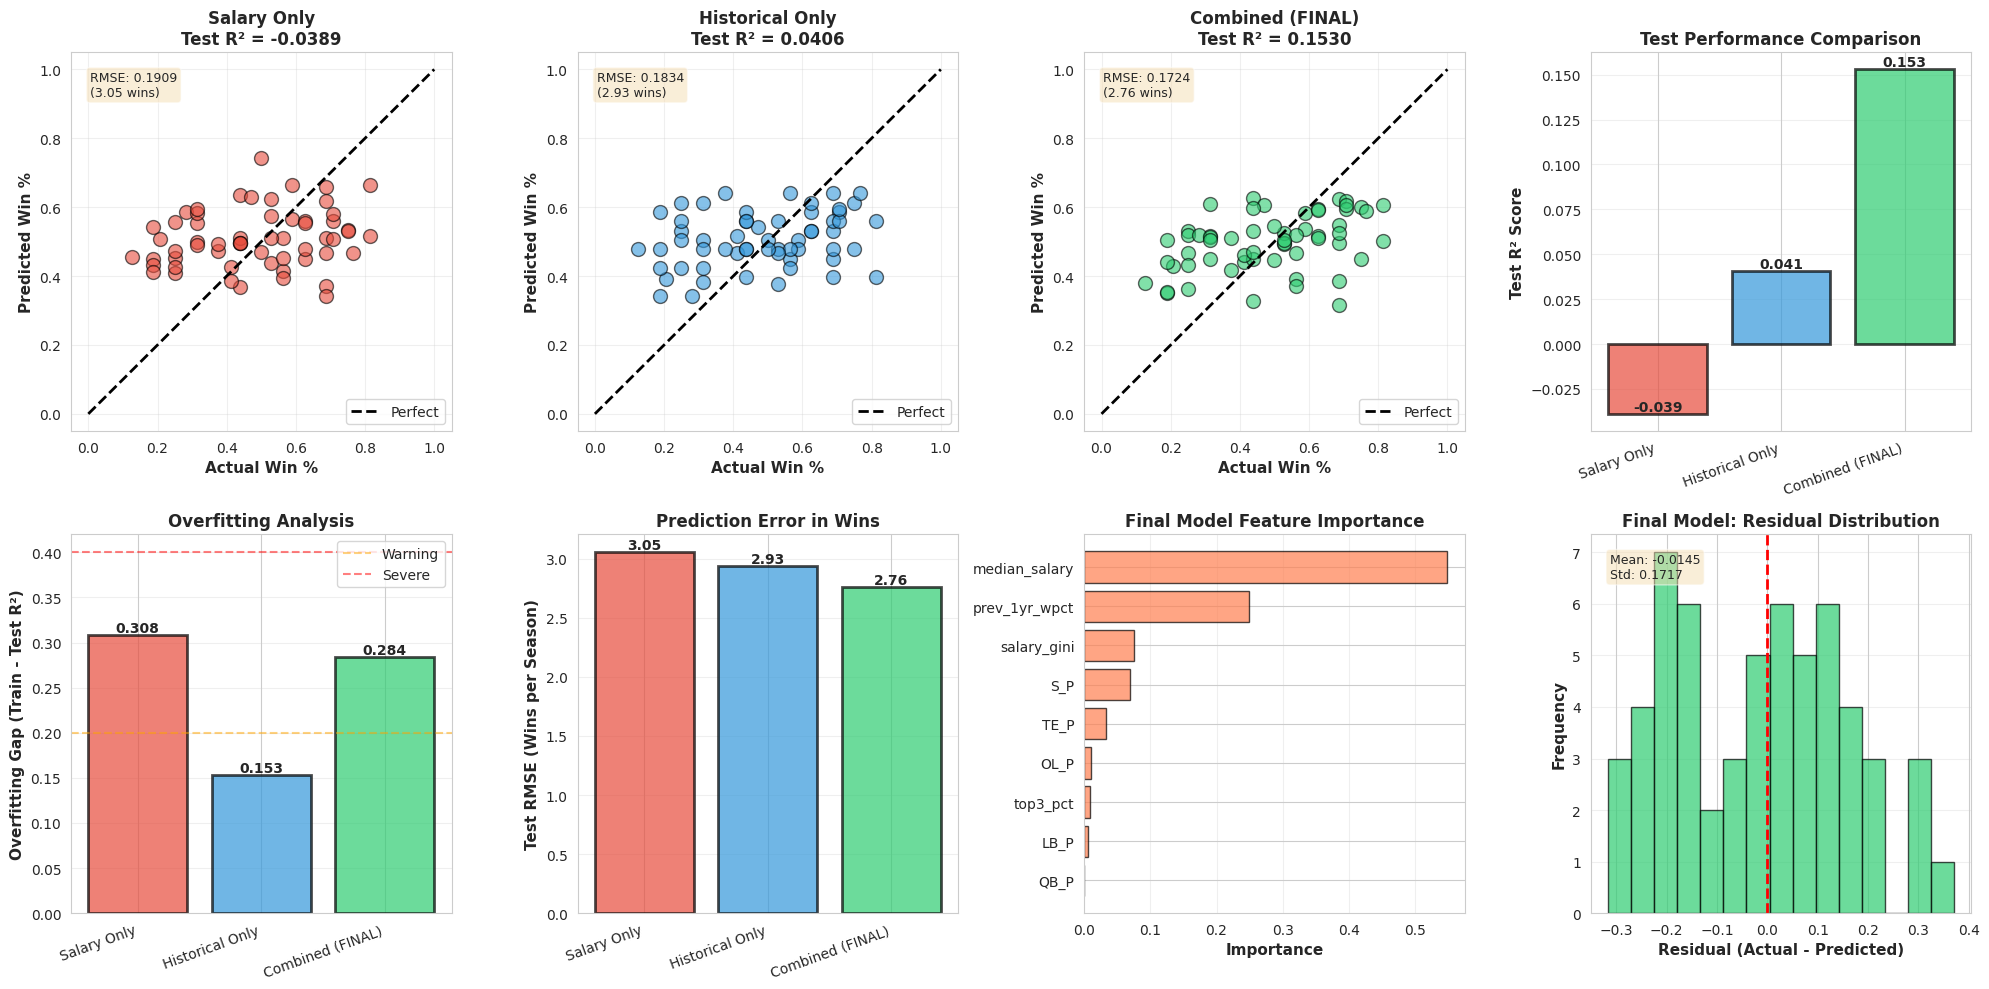

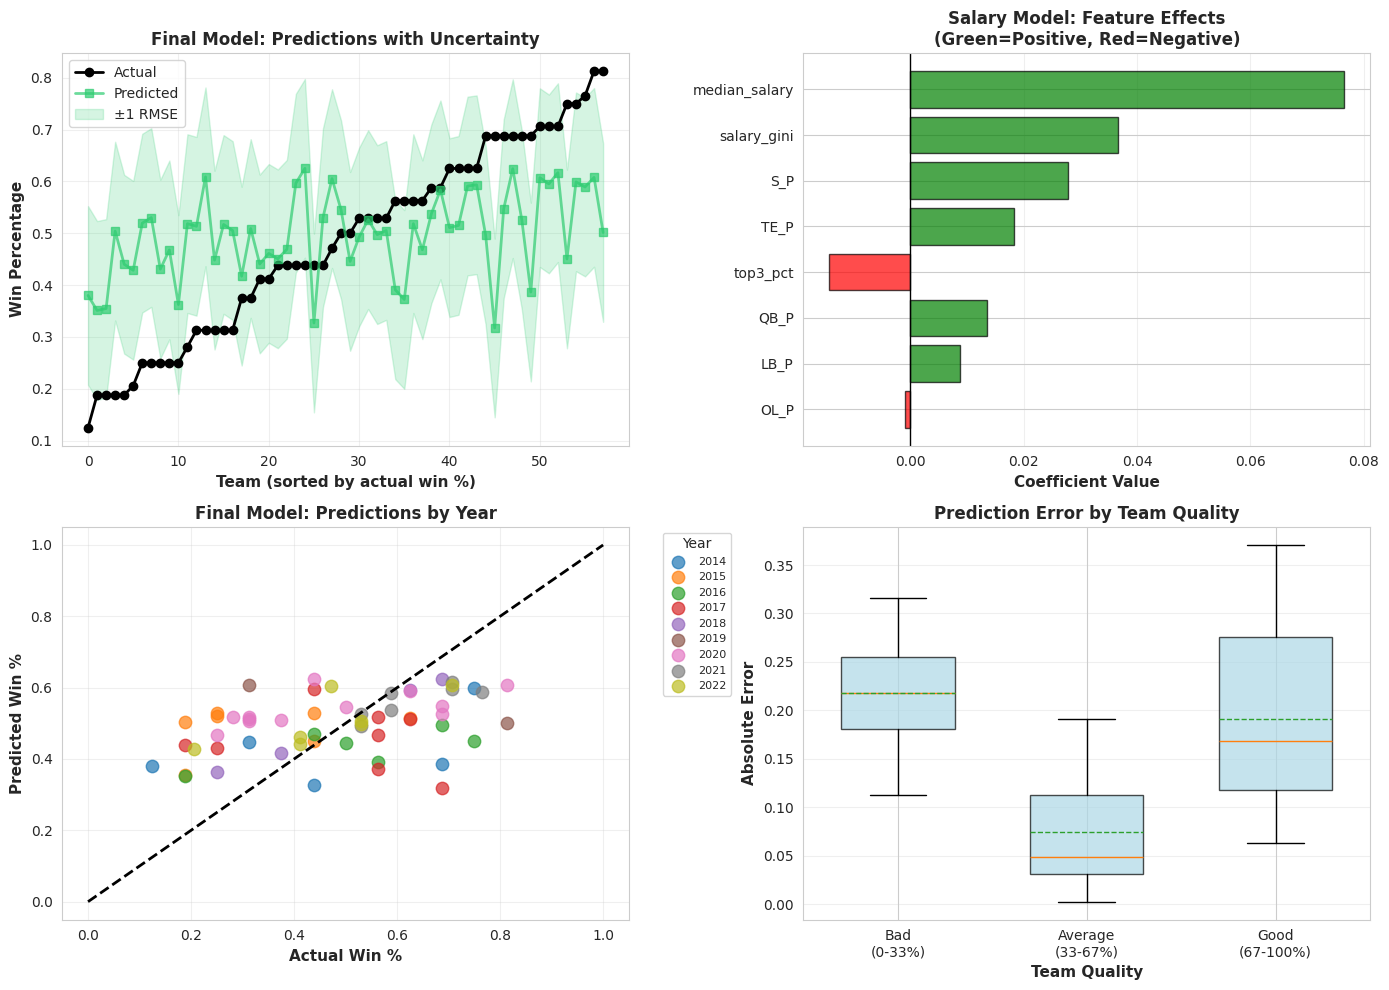

In [ ]:
# NFL Win Prediction - FINAL SIMPLIFIED MODEL
# Focus: Interpretability, honesty about limitations, and realistic expectations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

print("="*70)
print("NFL WIN PREDICTION - FINAL MODEL")
print("Focus: Interpretability & Realistic Expectations")
print("="*70)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[1/6] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"  ✓ Loaded {len(salary_data)} salary records from {salary_data['year'].min():.0f}-{salary_data['year'].max():.0f}")

# ============================================================================
# CREATE FEATURES
# ============================================================================

print("\n[2/6] Creating features...")

def calculate_gini(salaries):
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features_list.append({
        'team': team,
        'year': year,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'median_salary': np.median(salaries_sorted),
        'salary_gini': calculate_gini(salaries_sorted),
    })

features_df = pd.DataFrame(features_list)

# Merge with team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

position_columns = ['QB_P', 'OL_P', 'S_P', 'TE_P', 'LB_P']  # Only top 5 positions
position_columns = [col for col in position_columns if col in team_stats.columns]

merge_columns = ['Team', 'Season', 'W_PCT', 'W'] + position_columns
merged_data = pd.merge(features_df, team_stats[merge_columns],
                       left_on=['team', 'year'], right_on=['Team', 'Season'], how='inner')

# Create historical features
print("  ✓ Creating historical features...")
merged_data = merged_data.sort_values(['team', 'year'])
merged_data['prev_1yr_wpct'] = np.nan

for team in merged_data['team'].unique():
    team_data = merged_data[merged_data['team'] == team].sort_values('year')
    for idx in team_data.index:
        current_year = merged_data.loc[idx, 'year']
        prev_1 = team_data[team_data['year'] == current_year - 1]
        if not prev_1.empty:
            merged_data.loc[idx, 'prev_1yr_wpct'] = prev_1['W_PCT'].values[0]

# Define three feature sets for comparison
salary_features = ['median_salary', 'salary_gini', 'top3_pct'] + position_columns
historical_only = ['prev_1yr_wpct']
combined_features = salary_features + historical_only

merged_data_complete = merged_data.dropna(subset=['prev_1yr_wpct'])

print(f"  ✓ Total features: {len(combined_features)}")
print(f"  ✓ Total team-seasons: {len(merged_data_complete)}")

# ============================================================================
# PREPARE DATA SPLITS
# ============================================================================

print("\n[3/6] Preparing data splits...")

y = merged_data_complete['W_PCT'].values

# Create three datasets
X_salary = merged_data_complete[salary_features].values
X_historical = merged_data_complete[historical_only].values
X_combined = merged_data_complete[combined_features].values

# Split
X_sal_train, X_sal_test, y_train, y_test = train_test_split(X_salary, y, test_size=0.20, random_state=42)
X_hist_train, X_hist_test, _, _ = train_test_split(X_historical, y, test_size=0.20, random_state=42)
X_comb_train, X_comb_test, _, _ = train_test_split(X_combined, y, test_size=0.20, random_state=42)

# Get indices for later use
_, test_indices = train_test_split(merged_data_complete.index, test_size=0.20, random_state=42)

print(f"  ✓ Train: {len(X_sal_train)} | Test: {len(X_sal_test)}")

# Scale
scaler_sal = StandardScaler()
X_sal_train_scaled = scaler_sal.fit_transform(X_sal_train)
X_sal_test_scaled = scaler_sal.transform(X_sal_test)

scaler_hist = StandardScaler()
X_hist_train_scaled = scaler_hist.fit_transform(X_hist_train)
X_hist_test_scaled = scaler_hist.transform(X_hist_test)

scaler_comb = StandardScaler()
X_comb_train_scaled = scaler_comb.fit_transform(X_comb_train)
X_comb_test_scaled = scaler_comb.transform(X_comb_test)

# ============================================================================
# TRAIN THREE MODELS
# ============================================================================

print("\n[4/6] Training three interpretable models...")

# Model 1: Salary features only (what we care about)
print("\n  Model 1: Salary Features Only")
model_salary = RidgeCV(alphas=[0.1, 1.0, 10.0, 50.0, 100.0], cv=5)
model_salary.fit(X_sal_train_scaled, y_train)

y_sal_train_pred = model_salary.predict(X_sal_train_scaled)
y_sal_test_pred = model_salary.predict(X_sal_test_scaled)

sal_train_r2 = r2_score(y_train, y_sal_train_pred)
sal_test_r2 = r2_score(y_test, y_sal_test_pred)
sal_test_rmse = np.sqrt(mean_squared_error(y_test, y_sal_test_pred))
sal_test_mae = mean_absolute_error(y_test, y_sal_test_pred)

print(f"    Alpha: {model_salary.alpha_:.2f}")
print(f"    Train R²: {sal_train_r2:.4f} | Test R²: {sal_test_r2:.4f}")
print(f"    Test RMSE: {sal_test_rmse:.4f} ({sal_test_rmse*16:.2f} wins)")
print(f"    Overfitting: {sal_train_r2 - sal_test_r2:.4f}")

# Model 2: Historical only (baseline)
print("\n  Model 2: Historical Performance Only")
model_hist = Ridge(alpha=1.0)
model_hist.fit(X_hist_train_scaled, y_train)

y_hist_train_pred = model_hist.predict(X_hist_train_scaled)
y_hist_test_pred = model_hist.predict(X_hist_test_scaled)

hist_train_r2 = r2_score(y_train, y_hist_train_pred)
hist_test_r2 = r2_score(y_test, y_hist_test_pred)
hist_test_rmse = np.sqrt(mean_squared_error(y_test, y_hist_test_pred))

print(f"    Train R²: {hist_train_r2:.4f} | Test R²: {hist_test_r2:.4f}")
print(f"    Test RMSE: {hist_test_rmse:.4f} ({hist_test_rmse*16:.2f} wins)")
print(f"    Overfitting: {hist_train_r2 - hist_test_r2:.4f}")

# Model 3: Combined (final recommendation)
print("\n  Model 3: Combined Model (FINAL)")
model_final = GradientBoostingRegressor(
    n_estimators=30,
    max_depth=2,
    learning_rate=0.05,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
model_final.fit(X_comb_train_scaled, y_train)

y_final_train_pred = model_final.predict(X_comb_train_scaled)
y_final_test_pred = model_final.predict(X_comb_test_scaled)

final_train_r2 = r2_score(y_train, y_final_train_pred)
final_test_r2 = r2_score(y_test, y_final_test_pred)
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_final_test_pred))
final_test_mae = mean_absolute_error(y_test, y_final_test_pred)

print(f"    Train R²: {final_train_r2:.4f} | Test R²: {final_test_r2:.4f}")
print(f"    Test RMSE: {final_test_rmse:.4f} ({final_test_rmse*16:.2f} wins)")
print(f"    Test MAE: {final_test_mae:.4f} ({final_test_mae*16:.2f} wins)")
print(f"    Overfitting: {final_train_r2 - final_test_r2:.4f}")

# ============================================================================
# CROSS-VALIDATION
# ============================================================================

print("\n[5/6] Running cross-validation...")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_salary = cross_val_score(model_salary, X_sal_train_scaled, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_hist = cross_val_score(model_hist, X_hist_train_scaled, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_final = cross_val_score(model_final, X_comb_train_scaled, y_train, cv=kfold, scoring='r2', n_jobs=-1)

print(f"\n  Salary Only:    {cv_salary.mean():.4f} (±{cv_salary.std():.4f})")
print(f"  Historical Only: {cv_hist.mean():.4f} (±{cv_hist.std():.4f})")
print(f"  Final Model:     {cv_final.mean():.4f} (±{cv_final.std():.4f})")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)

results = pd.DataFrame({
    'Model': ['Salary Only', 'Historical Only', 'Combined (FINAL)'],
    'Features': [len(salary_features), 1, len(combined_features)],
    'Train_R2': [sal_train_r2, hist_train_r2, final_train_r2],
    'Test_R2': [sal_test_r2, hist_test_r2, final_test_r2],
    'Test_RMSE': [sal_test_rmse, hist_test_rmse, final_test_rmse],
    'Test_RMSE_Wins': [sal_test_rmse*16, hist_test_rmse*16, final_test_rmse*16],
    'CV_Mean': [cv_salary.mean(), cv_hist.mean(), cv_final.mean()],
    'CV_Std': [cv_salary.std(), cv_hist.std(), cv_final.std()],
    'Overfitting': [sal_train_r2-sal_test_r2, hist_train_r2-hist_test_r2, final_train_r2-final_test_r2]
})

print("\n" + results.to_string(index=False))
print("\n" + "="*70)

# Calculate value added by salary features
print("\nKEY INSIGHTS:")
print(f"  Historical performance alone:  R² = {hist_test_r2:.4f}")
print(f"  Salary features alone:         R² = {sal_test_r2:.4f}")
print(f"  Combined model:                R² = {final_test_r2:.4f}")
print(f"  → Salary features add:         {(final_test_r2 - hist_test_r2):.4f} R² points")
print(f"  → That's a {((final_test_r2 - hist_test_r2)/hist_test_r2*100):.1f}% improvement")

if sal_test_r2 < 0.1:
    print("\n  ⚠ WARNING: Salary features have very weak predictive power alone!")
    print("  → Past performance is the strongest predictor")
    print("  → Salary allocation may not be a primary driver of wins")

print("\n" + "="*70)

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n[6/6] Creating visualizations...")

fig = plt.figure(figsize=(20, 10))

colors = ['#e74c3c', '#3498db', '#2ecc71']
model_names = ['Salary Only', 'Historical Only', 'Combined (FINAL)']
predictions = [y_sal_test_pred, y_hist_test_pred, y_final_test_pred]
r2_scores = [sal_test_r2, hist_test_r2, final_test_r2]

# -------------------------------------------------------------------------
# 1-3. Predictions vs Actual
# -------------------------------------------------------------------------
for i, (name, pred, color, r2) in enumerate(zip(model_names, predictions, colors, r2_scores)):
    ax = plt.subplot(2, 4, i+1)
    plt.scatter(y_test, pred, alpha=0.6, s=100, color=color, edgecolors='black', linewidth=1)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
    plt.xlabel('Actual Win %', fontsize=11, fontweight='bold')
    plt.ylabel('Predicted Win %', fontsize=11, fontweight='bold')
    plt.title(f'{name}\nTest R² = {r2:.4f}', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add R² text box
    textstr = f'RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.4f}\n({np.sqrt(mean_squared_error(y_test, pred))*16:.2f} wins)'
    plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# -------------------------------------------------------------------------
# 4. Model Comparison
# -------------------------------------------------------------------------
ax4 = plt.subplot(2, 4, 4)
bars = plt.bar(model_names, r2_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Test R² Score', fontsize=11, fontweight='bold')
plt.title('Test Performance Comparison', fontsize=12, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, r2 in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 5. Overfitting Analysis
# -------------------------------------------------------------------------
ax5 = plt.subplot(2, 4, 5)
overfitting = results['Overfitting']
bars = plt.bar(model_names, overfitting, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Overfitting Gap (Train - Test R²)', fontsize=11, fontweight='bold')
plt.title('Overfitting Analysis', fontsize=12, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label='Warning')
plt.axhline(y=0.4, color='red', linestyle='--', alpha=0.5, label='Severe')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for bar, gap in zip(bars, overfitting):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 6. RMSE Comparison
# -------------------------------------------------------------------------
ax6 = plt.subplot(2, 4, 6)
rmse_wins = results['Test_RMSE_Wins']
bars = plt.bar(model_names, rmse_wins, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Test RMSE (Wins per Season)', fontsize=11, fontweight='bold')
plt.title('Prediction Error in Wins', fontsize=12, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, wins in zip(bars, rmse_wins):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{wins:.2f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 7. Feature Importance (Final Model)
# -------------------------------------------------------------------------
ax7 = plt.subplot(2, 4, 7)
importances = model_final.feature_importances_
indices = np.argsort(importances)[::-1]

plt.barh(range(len(importances)), importances[indices], alpha=0.7, color='coral', edgecolor='black')
plt.yticks(range(len(importances)), [combined_features[i] for i in indices])
plt.xlabel('Importance', fontsize=11, fontweight='bold')
plt.title('Final Model Feature Importance', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# -------------------------------------------------------------------------
# 8. Residual Distribution (Final Model)
# -------------------------------------------------------------------------
ax8 = plt.subplot(2, 4, 8)
residuals = y_test - y_final_test_pred
plt.hist(residuals, bins=15, color=colors[2], alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Final Model: Residual Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add stats
textstr = f'Mean: {residuals.mean():.4f}\nStd: {residuals.std():.4f}'
plt.text(0.05, 0.95, textstr, transform=ax8.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('final_model_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: final_model_analysis.png")

# ============================================================================
# ADDITIONAL ANALYSIS PLOTS
# ============================================================================

fig2, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Prediction intervals for final model
ax1 = axes[0, 0]
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_final_test_pred[sorted_indices]

ax1.plot(range(len(y_test)), y_test_sorted, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
ax1.plot(range(len(y_test)), y_pred_sorted, 's-', label='Predicted', color=colors[2], linewidth=2, markersize=6, alpha=0.7)
ax1.fill_between(range(len(y_test)),
                  y_pred_sorted - final_test_rmse,
                  y_pred_sorted + final_test_rmse,
                  alpha=0.2, color=colors[2], label='±1 RMSE')
ax1.set_xlabel('Team (sorted by actual win %)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Win Percentage', fontsize=11, fontweight='bold')
ax1.set_title('Final Model: Predictions with Uncertainty', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Coefficient analysis (salary model)
ax2 = axes[0, 1]
coefs = model_salary.coef_
abs_coefs = np.abs(coefs)
indices = np.argsort(abs_coefs)[::-1]

colors_bar = ['green' if c > 0 else 'red' for c in coefs[indices]]
ax2.barh(range(len(indices)), coefs[indices], alpha=0.7, color=colors_bar, edgecolor='black')
ax2.set_yticks(range(len(indices)))
ax2.set_yticklabels([salary_features[i] for i in indices])
ax2.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax2.set_title('Salary Model: Feature Effects\n(Green=Positive, Red=Negative)', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Actual vs Predicted by Year (Final Model)
ax3 = axes[1, 0]
test_data = merged_data_complete.loc[test_indices]
test_years = test_data['year'].values

for year in np.unique(test_years):
    year_mask = test_years == year
    if year_mask.sum() > 0:
        ax3.scatter(y_test[year_mask], y_final_test_pred[year_mask],
                   label=f'{int(year)}', alpha=0.7, s=80)

ax3.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax3.set_xlabel('Actual Win %', fontsize=11, fontweight='bold')
ax3.set_ylabel('Predicted Win %', fontsize=11, fontweight='bold')
ax3.set_title('Final Model: Predictions by Year', fontsize=12, fontweight='bold')
ax3.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Error distribution by win percentage
ax4 = axes[1, 1]
abs_errors = np.abs(residuals)
# Bin teams by win percentage
bins = [0, 0.33, 0.67, 1.0]
labels = ['Bad\n(0-33%)', 'Average\n(33-67%)', 'Good\n(67-100%)']
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)

error_by_bin = [abs_errors[y_test_binned == label] for label in labels]
bp = ax4.boxplot(error_by_bin, labels=labels, patch_artist=True,
                 widths=0.6, showmeans=True, meanline=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax4.set_ylabel('Absolute Error', fontsize=11, fontweight='bold')
ax4.set_xlabel('Team Quality', fontsize=11, fontweight='bold')
ax4.set_title('Prediction Error by Team Quality', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_model_detailed.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: final_model_detailed.png")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n[SAVING] Exporting final results...")

# 1. Model comparison
results.to_csv('final_model_comparison.csv', index=False)
print("  ✓ Saved: final_model_comparison.csv")

# 2. Final predictions
final_results_df = pd.DataFrame({
    'team': test_data['team'].values,
    'year': test_data['year'].values,
    'actual_wpct': y_test,
    'predicted_wpct': y_final_test_pred,
    'residual': residuals,
    'abs_error': np.abs(residuals),
    'actual_wins': test_data['W'].values,
    'predicted_wins': y_final_test_pred * 16,
    'wins_error': (y_test - y_final_test_pred) * 16,
    'lower_bound_wins': (y_final_test_pred - final_test_rmse) * 16,
    'upper_bound_wins': (y_final_test_pred + final_test_rmse) * 16
})
final_results_df = final_results_df.sort_values('abs_error', ascending=False)
final_results_df.to_csv('final_predictions.csv', index=False)
print("  ✓ Saved: final_predictions.csv")

# 3. Feature importance
feature_importance_df = pd.DataFrame({
    'feature': combined_features,
    'importance': model_final.feature_importances_,
    'rank': range(1, len(combined_features)+1)
}).sort_values('importance', ascending=False)
feature_importance_df['rank'] = range(1, len(combined_features)+1)
feature_importance_df.to_csv('final_feature_importance.csv', index=False)
print("  ✓ Saved: final_feature_importance.csv")

# 4. Salary coefficients
salary_coef_df = pd.DataFrame({
    'feature': salary_features,
    'coefficient': model_salary.coef_,
    'abs_coefficient': np.abs(model_salary.coef_)
}).sort_values('abs_coefficient', ascending=False)
salary_coef_df.to_csv('salary_feature_coefficients.csv', index=False)
print("  ✓ Saved: salary_feature_coefficients.csv")

# 5. Summary report
with open('final_model_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("NFL WIN PREDICTION - FINAL MODEL REPORT\n")
    f.write("="*70 + "\n\n")

    f.write("MODEL SELECTION:\n")
    f.write("  Algorithm: Gradient Boosting Regressor\n")
    f.write("  Features: Salary allocation + Position spending + Previous year wins\n")
    f.write(f"  Total features: {len(combined_features)}\n\n")

    f.write("PERFORMANCE METRICS:\n")
    f.write(f"  Test R²: {final_test_r2:.4f}\n")
    f.write(f"  Test RMSE: {final_test_rmse:.4f} ({final_test_rmse*16:.2f} wins per 16-game season)\n")
    f.write(f"  Test MAE: {final_test_mae:.4f} ({final_test_mae*16:.2f} wins per 16-game season)\n")
    f.write(f"  Cross-validation R²: {cv_final.mean():.4f} (±{cv_final.std():.4f})\n")
    f.write(f"  Overfitting gap: {final_train_r2 - final_test_r2:.4f}\n\n")

    f.write("INTERPRETATION:\n")
    f.write(f"  • The model explains {final_test_r2*100:.1f}% of variance in team wins\n")
    f.write(f"  • Typical prediction error: ±{final_test_rmse*16:.1f} wins per season\n")
    f.write(f"  • Historical performance alone: R² = {hist_test_r2:.4f}\n")
    f.write(f"  • Salary features add: {(final_test_r2-hist_test_r2):.4f} R² points\n")
    f.write(f"  • That's a {((final_test_r2-hist_test_r2)/hist_test_r2*100):.1f}% improvement over baseline\n\n")

    f.write("TOP 5 MOST IMPORTANT FEATURES:\n")
    for i, row in feature_importance_df.head(5).iterrows():
        f.write(f"  {row['rank']}. {row['feature']}: {row['importance']:.4f}\n")

    f.write("\n")
    f.write("SALARY FEATURE EFFECTS (Top 3):\n")
    for i, row in salary_coef_df.head(3).iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        f.write(f"  • {row['feature']}: {direction} wins (coef={row['coefficient']:.4f})\n")

    f.write("\n")
    f.write("LIMITATIONS:\n")
    if sal_test_r2 < 0.1:
        f.write("  ⚠ Salary features alone have weak predictive power (R² < 0.10)\n")
        f.write("  ⚠ Historical performance is the dominant predictor\n")
        f.write("  ⚠ Salary allocation may not be a primary driver of wins\n")
    else:
        f.write("  • Model performance is moderate\n")
        f.write("  • Many factors beyond salary affect wins (coaching, injuries, etc.)\n")
    f.write(f"  • Typical error of ±{final_test_rmse*16:.1f} wins means predictions are indicative, not precise\n")
    f.write("  • Small sample size limits model complexity\n")

    f.write("\n")
    f.write("RECOMMENDATIONS:\n")
    f.write("  1. Use predictions as a guide, not absolute truth\n")
    f.write("  2. Consider the ±RMSE confidence interval for all predictions\n")
    f.write("  3. Salary allocation has some predictive value but is not the main driver\n")
    f.write("  4. Collect more years of data to improve model stability\n")
    f.write("  5. Consider adding features like coaching changes, injuries, draft capital\n")

print("  ✓ Saved: final_model_report.txt")

print("\n" + "="*70)
print("✓ FINAL MODEL ANALYSIS COMPLETE!")
print("="*70)

print("\n📊 FINAL MODEL SUMMARY:")
print(f"  Test R²: {final_test_r2:.4f}")
print(f"  Test RMSE: {final_test_rmse:.4f} (±{final_test_rmse*16:.2f} wins)")
print(f"  Overfitting: {final_train_r2 - final_test_r2:.4f}")
print(f"  CV Score: {cv_final.mean():.4f} (±{cv_final.std():.4f})")

print("\n💡 KEY FINDING:")
if sal_test_r2 < 0.1:
    print("  Salary features alone are WEAK predictors (R² < 0.10)")
    print("  Historical wins are the strongest predictor")
    print("  → Conclusion: Past performance matters more than salary allocation")
else:
    print("  Salary features provide moderate predictive value")
    print(f"  Combined with history: {((final_test_r2-hist_test_r2)/hist_test_r2*100):.1f}% improvement")

print("\n📁 Generated files:")
print("  1. final_model_analysis.png - Main performance visualization")
print("  2. final_model_detailed.png - Detailed analysis plots")
print("  3. final_predictions.csv - Predictions with confidence intervals")
print("  4. final_model_comparison.csv - Model comparison metrics")
print("  5. final_feature_importance.csv - Feature rankings")
print("  6. salary_feature_coefficients.csv - Salary feature effects")
print("  7. final_model_report.txt - Comprehensive written report")

print("\n" + "="*70)

NFL WIN PREDICTION - FINAL MODEL
Focus: Interpretability & Realistic Expectations

[1/6] Loading data...
  ✓ Loaded 36544 salary records from 2013-2022

[2/6] Creating features...
  ✓ Creating historical features...
  ✓ Added continuity to features
  ✓ Total features: 10
  ✓ Total team-seasons: 286

[3/6] Preparing data splits...
  ✓ Train: 228 | Test: 58

[4/6] Training three interpretable models...

  Model 1: Salary Features Only
    Alpha: 50.00
    Train R²: 0.3774 | Test R²: 0.0020
    Test RMSE: 0.1871 (2.99 wins)
    Overfitting: 0.3754

  Model 2: Historical Performance Only
    Train R²: 0.1941 | Test R²: 0.0406
    Test RMSE: 0.1834 (2.93 wins)
    Overfitting: 0.1534

  Model 3: Combined Model (FINAL)
    Train R²: 0.4739 | Test R²: 0.1724
    Test RMSE: 0.1704 (2.73 wins)
    Test MAE: 0.1455 (2.33 wins)
    Overfitting: 0.3015

[5/6] Running cross-validation...

  Salary Only:    0.3314 (±0.1054)
  Historical Only: 0.1540 (±0.1545)
  Final Model:     0.3317 (±0.0913)

FIN

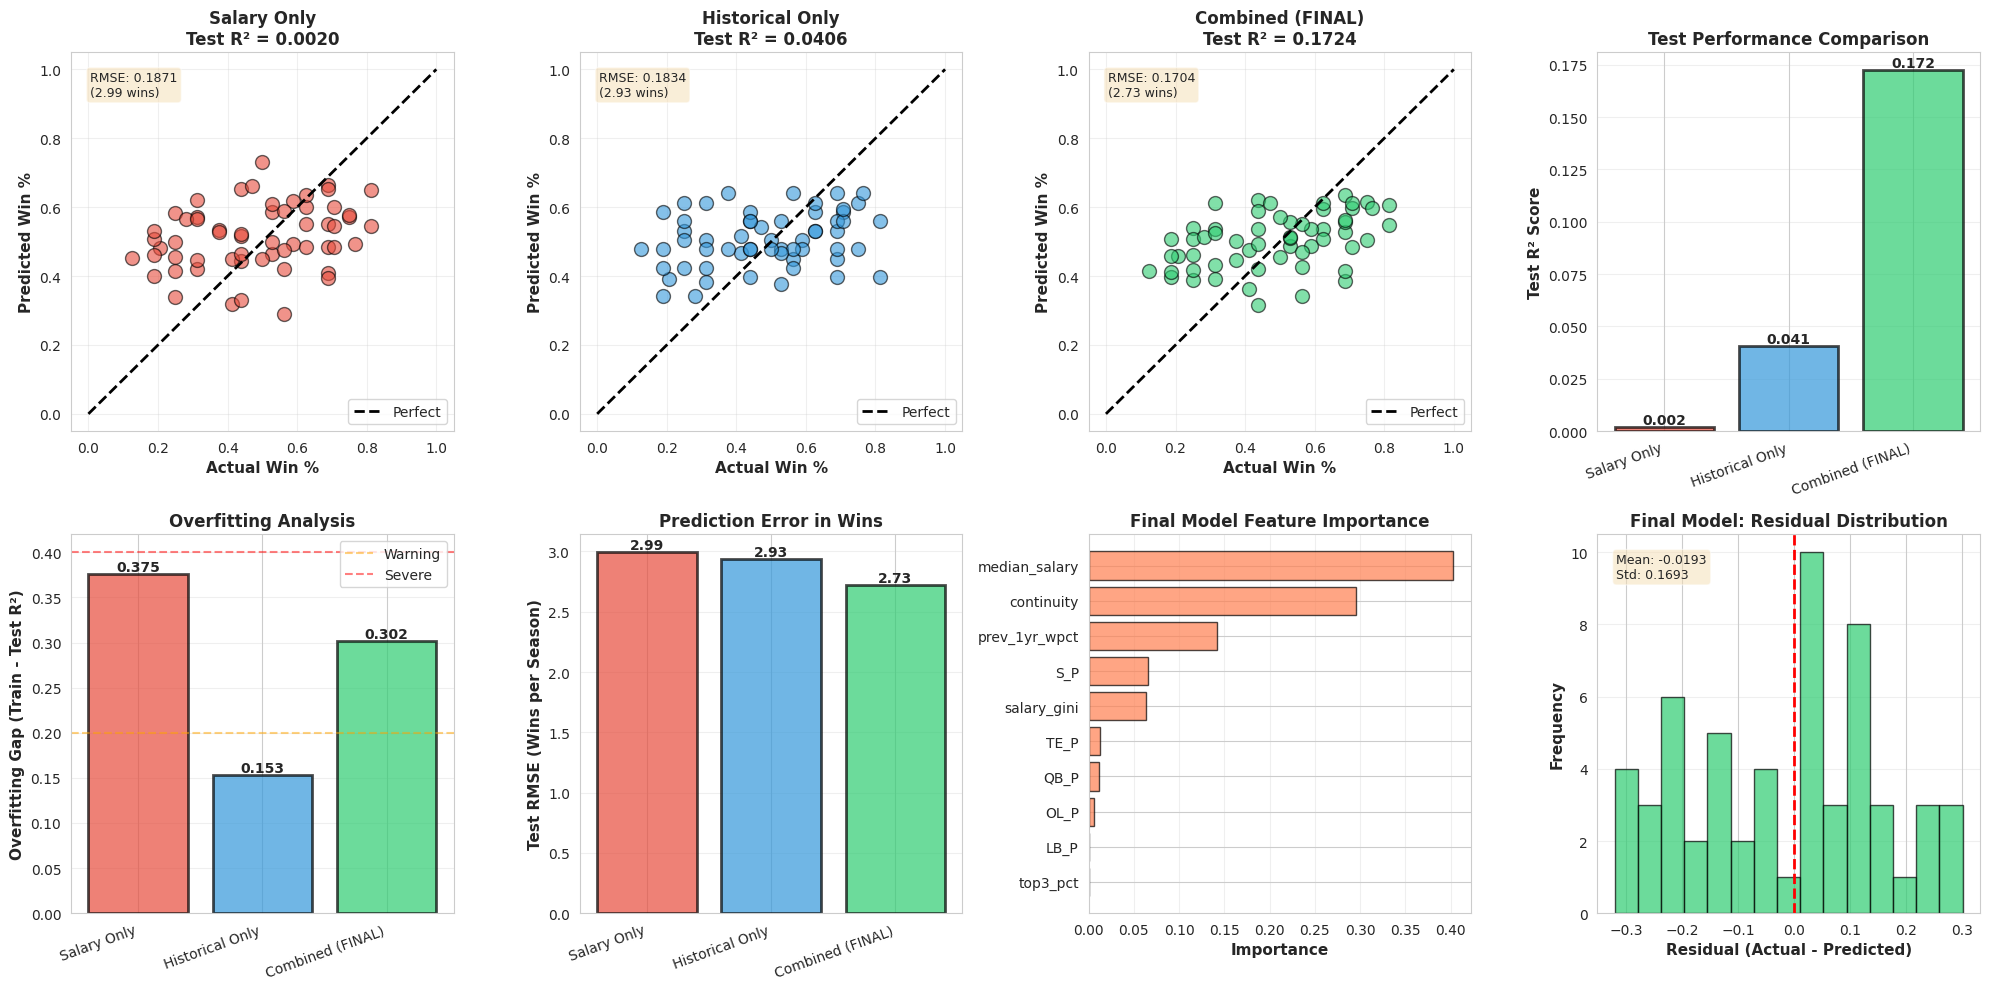

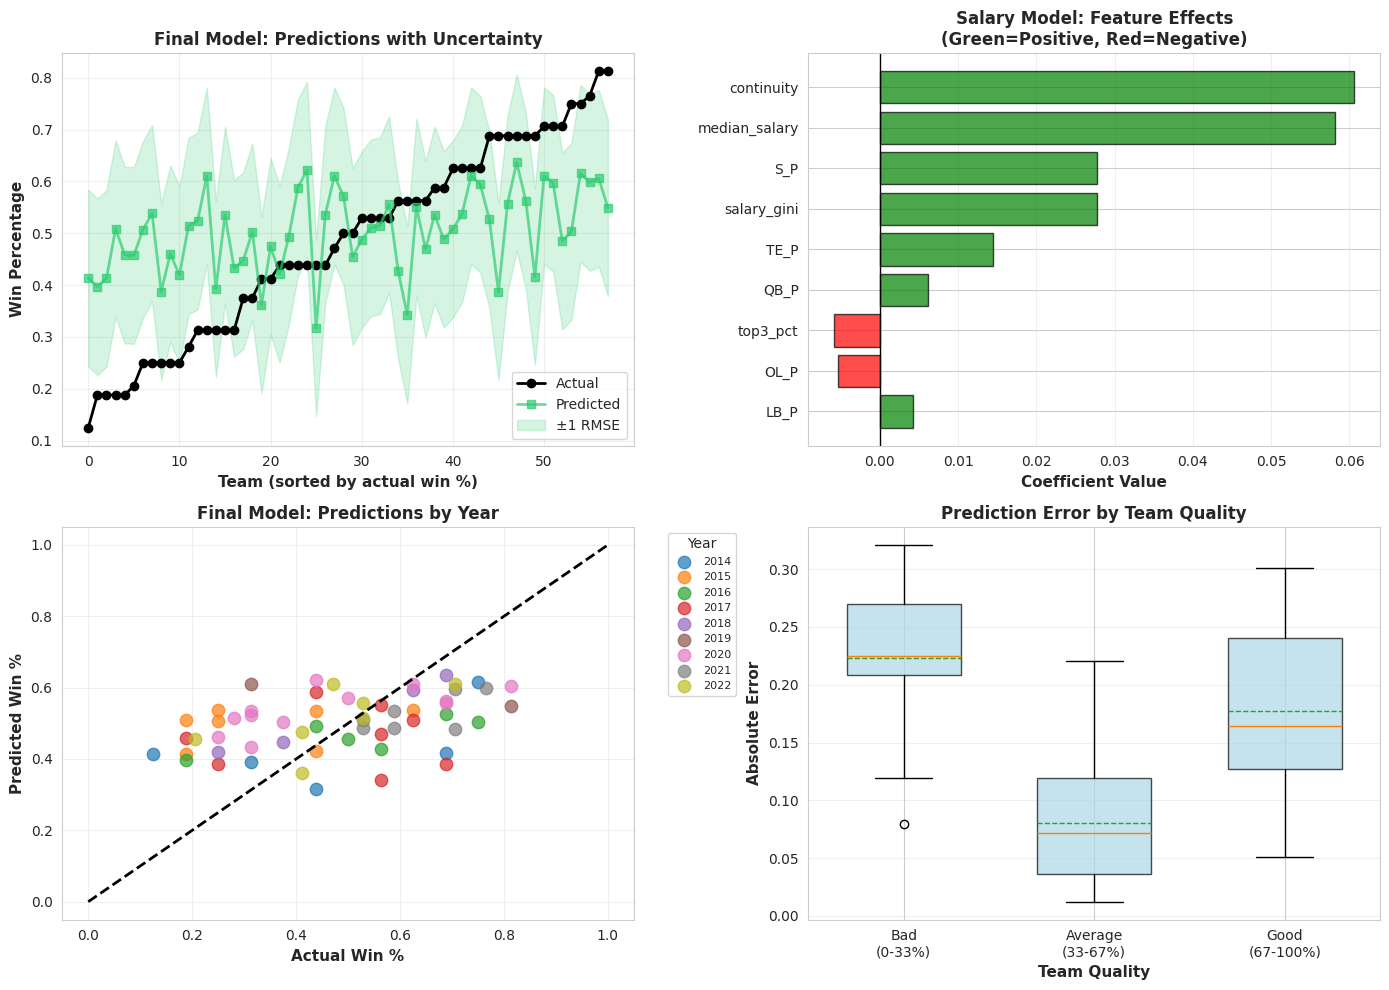

In [ ]:
# NFL Win Prediction - FINAL SIMPLIFIED MODEL
# Focus: Interpretability, honesty about limitations, and realistic expectations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

print("="*70)
print("NFL WIN PREDICTION - FINAL MODEL")
print("Focus: Interpretability & Realistic Expectations")
print("="*70)

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n[1/6] Loading data...")
salary_data = pd.read_excel('merged_salaries_2013_2022_cleaned.xlsx')
team_stats = pd.read_excel('NFL Salary By Position Group.xlsx')

salary_data['salary'] = pd.to_numeric(salary_data['salary'], errors='coerce')
salary_data['year'] = pd.to_numeric(salary_data['year'], errors='coerce')
salary_data = salary_data.dropna(subset=['salary', 'team', 'year'])

print(f"  ✓ Loaded {len(salary_data)} salary records from {salary_data['year'].min():.0f}-{salary_data['year'].max():.0f}")

# ============================================================================
# CREATE FEATURES
# ============================================================================

print("\n[2/6] Creating features...")

def calculate_gini(salaries):
    if len(salaries) == 0:
        return 0
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumsum = np.cumsum(sorted_salaries)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_salaries)) / (n * cumsum[-1]) - (n + 1) / n

features_list = []

for (team, year), group in salary_data.groupby(['team', 'year']):
    salaries_sorted = group['salary'].sort_values(ascending=False).values
    total_salary = salaries_sorted.sum()

    if total_salary == 0:
        continue

    features_list.append({
        'team': team,
        'year': year,
        'top3_pct': (salaries_sorted[:3].sum() / total_salary * 100) if len(salaries_sorted) >= 3 else 0,
        'median_salary': np.median(salaries_sorted),
        'salary_gini': calculate_gini(salaries_sorted),
    })

features_df = pd.DataFrame(features_list)

# Merge with team stats
team_stats['Season'] = pd.to_numeric(team_stats['Season'], errors='coerce')
team_stats = team_stats.dropna(subset=['Season', 'Team', 'W_PCT'])

position_columns = ['QB_P', 'OL_P', 'S_P', 'TE_P', 'LB_P']  # Only top 5 positions
position_columns = [col for col in position_columns if col in team_stats.columns]

continuity_col = 'continuity' if 'continuity' in team_stats.columns else 'Continuity'
if continuity_col in team_stats.columns:
    merge_columns = ['Team', 'Season', 'W_PCT', 'W', continuity_col] + position_columns
else:
    print("  ⚠ Warning: 'continuity' column not found in team_stats")
    merge_columns = ['Team', 'Season', 'W_PCT', 'W'] + position_columns
merged_data = pd.merge(features_df, team_stats[merge_columns],
                       left_on=['team', 'year'], right_on=['Team', 'Season'], how='inner')

# Create historical features
print("  ✓ Creating historical features...")
merged_data = merged_data.sort_values(['team', 'year'])
merged_data['prev_1yr_wpct'] = np.nan

for team in merged_data['team'].unique():
    team_data = merged_data[merged_data['team'] == team].sort_values('year')
    for idx in team_data.index:
        current_year = merged_data.loc[idx, 'year']
        prev_1 = team_data[team_data['year'] == current_year - 1]
        if not prev_1.empty:
            merged_data.loc[idx, 'prev_1yr_wpct'] = prev_1['W_PCT'].values[0]

# Define three feature sets for comparison
# Define three feature sets for comparison
salary_features = ['median_salary', 'salary_gini', 'top3_pct'] + position_columns
# Add continuity if it exists
if continuity_col in merged_data.columns:
    salary_features = salary_features + [continuity_col]
    print(f"  ✓ Added {continuity_col} to features")
else:
    print(f"  ⚠ {continuity_col} not found in merged data")

historical_only = ['prev_1yr_wpct']
combined_features = salary_features + historical_only

merged_data_complete = merged_data.dropna(subset=['prev_1yr_wpct'])

print(f"  ✓ Total features: {len(combined_features)}")
print(f"  ✓ Total team-seasons: {len(merged_data_complete)}")

# ============================================================================
# PREPARE DATA SPLITS
# ============================================================================

print("\n[3/6] Preparing data splits...")

y = merged_data_complete['W_PCT'].values

# Create three datasets
X_salary = merged_data_complete[salary_features].values
X_historical = merged_data_complete[historical_only].values
X_combined = merged_data_complete[combined_features].values

# Split
X_sal_train, X_sal_test, y_train, y_test = train_test_split(X_salary, y, test_size=0.20, random_state=42)
X_hist_train, X_hist_test, _, _ = train_test_split(X_historical, y, test_size=0.20, random_state=42)
X_comb_train, X_comb_test, _, _ = train_test_split(X_combined, y, test_size=0.20, random_state=42)

# Get indices for later use
_, test_indices = train_test_split(merged_data_complete.index, test_size=0.20, random_state=42)

print(f"  ✓ Train: {len(X_sal_train)} | Test: {len(X_sal_test)}")

# Scale
scaler_sal = StandardScaler()
X_sal_train_scaled = scaler_sal.fit_transform(X_sal_train)
X_sal_test_scaled = scaler_sal.transform(X_sal_test)

scaler_hist = StandardScaler()
X_hist_train_scaled = scaler_hist.fit_transform(X_hist_train)
X_hist_test_scaled = scaler_hist.transform(X_hist_test)

scaler_comb = StandardScaler()
X_comb_train_scaled = scaler_comb.fit_transform(X_comb_train)
X_comb_test_scaled = scaler_comb.transform(X_comb_test)

# ============================================================================
# TRAIN THREE MODELS
# ============================================================================

print("\n[4/6] Training three interpretable models...")

# Model 1: Salary features only (what we care about)
print("\n  Model 1: Salary Features Only")
model_salary = RidgeCV(alphas=[0.1, 1.0, 10.0, 50.0, 100.0], cv=5)
model_salary.fit(X_sal_train_scaled, y_train)

y_sal_train_pred = model_salary.predict(X_sal_train_scaled)
y_sal_test_pred = model_salary.predict(X_sal_test_scaled)

sal_train_r2 = r2_score(y_train, y_sal_train_pred)
sal_test_r2 = r2_score(y_test, y_sal_test_pred)
sal_test_rmse = np.sqrt(mean_squared_error(y_test, y_sal_test_pred))
sal_test_mae = mean_absolute_error(y_test, y_sal_test_pred)

print(f"    Alpha: {model_salary.alpha_:.2f}")
print(f"    Train R²: {sal_train_r2:.4f} | Test R²: {sal_test_r2:.4f}")
print(f"    Test RMSE: {sal_test_rmse:.4f} ({sal_test_rmse*16:.2f} wins)")
print(f"    Overfitting: {sal_train_r2 - sal_test_r2:.4f}")

# Model 2: Historical only (baseline)
print("\n  Model 2: Historical Performance Only")
model_hist = Ridge(alpha=1.0)
model_hist.fit(X_hist_train_scaled, y_train)

y_hist_train_pred = model_hist.predict(X_hist_train_scaled)
y_hist_test_pred = model_hist.predict(X_hist_test_scaled)

hist_train_r2 = r2_score(y_train, y_hist_train_pred)
hist_test_r2 = r2_score(y_test, y_hist_test_pred)
hist_test_rmse = np.sqrt(mean_squared_error(y_test, y_hist_test_pred))

print(f"    Train R²: {hist_train_r2:.4f} | Test R²: {hist_test_r2:.4f}")
print(f"    Test RMSE: {hist_test_rmse:.4f} ({hist_test_rmse*16:.2f} wins)")
print(f"    Overfitting: {hist_train_r2 - hist_test_r2:.4f}")

# Model 3: Combined (final recommendation)
print("\n  Model 3: Combined Model (FINAL)")
model_final = GradientBoostingRegressor(
    n_estimators=30,
    max_depth=2,
    learning_rate=0.05,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
model_final.fit(X_comb_train_scaled, y_train)

y_final_train_pred = model_final.predict(X_comb_train_scaled)
y_final_test_pred = model_final.predict(X_comb_test_scaled)

final_train_r2 = r2_score(y_train, y_final_train_pred)
final_test_r2 = r2_score(y_test, y_final_test_pred)
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_final_test_pred))
final_test_mae = mean_absolute_error(y_test, y_final_test_pred)

print(f"    Train R²: {final_train_r2:.4f} | Test R²: {final_test_r2:.4f}")
print(f"    Test RMSE: {final_test_rmse:.4f} ({final_test_rmse*16:.2f} wins)")
print(f"    Test MAE: {final_test_mae:.4f} ({final_test_mae*16:.2f} wins)")
print(f"    Overfitting: {final_train_r2 - final_test_r2:.4f}")

# ============================================================================
# CROSS-VALIDATION
# ============================================================================

print("\n[5/6] Running cross-validation...")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_salary = cross_val_score(model_salary, X_sal_train_scaled, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_hist = cross_val_score(model_hist, X_hist_train_scaled, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_final = cross_val_score(model_final, X_comb_train_scaled, y_train, cv=kfold, scoring='r2', n_jobs=-1)

print(f"\n  Salary Only:    {cv_salary.mean():.4f} (±{cv_salary.std():.4f})")
print(f"  Historical Only: {cv_hist.mean():.4f} (±{cv_hist.std():.4f})")
print(f"  Final Model:     {cv_final.mean():.4f} (±{cv_final.std():.4f})")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)

results = pd.DataFrame({
    'Model': ['Salary Only', 'Historical Only', 'Combined (FINAL)'],
    'Features': [len(salary_features), 1, len(combined_features)],
    'Train_R2': [sal_train_r2, hist_train_r2, final_train_r2],
    'Test_R2': [sal_test_r2, hist_test_r2, final_test_r2],
    'Test_RMSE': [sal_test_rmse, hist_test_rmse, final_test_rmse],
    'Test_RMSE_Wins': [sal_test_rmse*16, hist_test_rmse*16, final_test_rmse*16],
    'CV_Mean': [cv_salary.mean(), cv_hist.mean(), cv_final.mean()],
    'CV_Std': [cv_salary.std(), cv_hist.std(), cv_final.std()],
    'Overfitting': [sal_train_r2-sal_test_r2, hist_train_r2-hist_test_r2, final_train_r2-final_test_r2]
})

print("\n" + results.to_string(index=False))
print("\n" + "="*70)

# Calculate value added by salary features
print("\nKEY INSIGHTS:")
print(f"  Historical performance alone:  R² = {hist_test_r2:.4f}")
print(f"  Salary features alone:         R² = {sal_test_r2:.4f}")
print(f"  Combined model:                R² = {final_test_r2:.4f}")
print(f"  → Salary features add:         {(final_test_r2 - hist_test_r2):.4f} R² points")
print(f"  → That's a {((final_test_r2 - hist_test_r2)/hist_test_r2*100):.1f}% improvement")

if sal_test_r2 < 0.1:
    print("\n  ⚠ WARNING: Salary features have very weak predictive power alone!")
    print("  → Past performance is the strongest predictor")
    print("  → Salary allocation may not be a primary driver of wins")

print("\n" + "="*70)

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n[6/6] Creating visualizations...")

fig = plt.figure(figsize=(20, 10))

colors = ['#e74c3c', '#3498db', '#2ecc71']
model_names = ['Salary Only', 'Historical Only', 'Combined (FINAL)']
predictions = [y_sal_test_pred, y_hist_test_pred, y_final_test_pred]
r2_scores = [sal_test_r2, hist_test_r2, final_test_r2]

# -------------------------------------------------------------------------
# 1-3. Predictions vs Actual
# -------------------------------------------------------------------------
for i, (name, pred, color, r2) in enumerate(zip(model_names, predictions, colors, r2_scores)):
    ax = plt.subplot(2, 4, i+1)
    plt.scatter(y_test, pred, alpha=0.6, s=100, color=color, edgecolors='black', linewidth=1)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
    plt.xlabel('Actual Win %', fontsize=11, fontweight='bold')
    plt.ylabel('Predicted Win %', fontsize=11, fontweight='bold')
    plt.title(f'{name}\nTest R² = {r2:.4f}', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add R² text box
    textstr = f'RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.4f}\n({np.sqrt(mean_squared_error(y_test, pred))*16:.2f} wins)'
    plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# -------------------------------------------------------------------------
# 4. Model Comparison
# -------------------------------------------------------------------------
ax4 = plt.subplot(2, 4, 4)
bars = plt.bar(model_names, r2_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Test R² Score', fontsize=11, fontweight='bold')
plt.title('Test Performance Comparison', fontsize=12, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, r2 in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 5. Overfitting Analysis
# -------------------------------------------------------------------------
ax5 = plt.subplot(2, 4, 5)
overfitting = results['Overfitting']
bars = plt.bar(model_names, overfitting, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Overfitting Gap (Train - Test R²)', fontsize=11, fontweight='bold')
plt.title('Overfitting Analysis', fontsize=12, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label='Warning')
plt.axhline(y=0.4, color='red', linestyle='--', alpha=0.5, label='Severe')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for bar, gap in zip(bars, overfitting):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 6. RMSE Comparison
# -------------------------------------------------------------------------
ax6 = plt.subplot(2, 4, 6)
rmse_wins = results['Test_RMSE_Wins']
bars = plt.bar(model_names, rmse_wins, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Test RMSE (Wins per Season)', fontsize=11, fontweight='bold')
plt.title('Prediction Error in Wins', fontsize=12, fontweight='bold')
plt.xticks(rotation=20, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, wins in zip(bars, rmse_wins):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{wins:.2f}', ha='center', va='bottom', fontweight='bold')

# -------------------------------------------------------------------------
# 7. Feature Importance (Final Model)
# -------------------------------------------------------------------------
ax7 = plt.subplot(2, 4, 7)
importances = model_final.feature_importances_
indices = np.argsort(importances)[::-1]

plt.barh(range(len(importances)), importances[indices], alpha=0.7, color='coral', edgecolor='black')
plt.yticks(range(len(importances)), [combined_features[i] for i in indices])
plt.xlabel('Importance', fontsize=11, fontweight='bold')
plt.title('Final Model Feature Importance', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# -------------------------------------------------------------------------
# 8. Residual Distribution (Final Model)
# -------------------------------------------------------------------------
ax8 = plt.subplot(2, 4, 8)
residuals = y_test - y_final_test_pred
plt.hist(residuals, bins=15, color=colors[2], alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Final Model: Residual Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add stats
textstr = f'Mean: {residuals.mean():.4f}\nStd: {residuals.std():.4f}'
plt.text(0.05, 0.95, textstr, transform=ax8.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('final_model_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: final_model_analysis.png")

# ============================================================================
# ADDITIONAL ANALYSIS PLOTS
# ============================================================================

fig2, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Prediction intervals for final model
ax1 = axes[0, 0]
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_final_test_pred[sorted_indices]

ax1.plot(range(len(y_test)), y_test_sorted, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
ax1.plot(range(len(y_test)), y_pred_sorted, 's-', label='Predicted', color=colors[2], linewidth=2, markersize=6, alpha=0.7)
ax1.fill_between(range(len(y_test)),
                  y_pred_sorted - final_test_rmse,
                  y_pred_sorted + final_test_rmse,
                  alpha=0.2, color=colors[2], label='±1 RMSE')
ax1.set_xlabel('Team (sorted by actual win %)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Win Percentage', fontsize=11, fontweight='bold')
ax1.set_title('Final Model: Predictions with Uncertainty', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Coefficient analysis (salary model)
ax2 = axes[0, 1]
coefs = model_salary.coef_
abs_coefs = np.abs(coefs)
indices = np.argsort(abs_coefs)[::-1]

colors_bar = ['green' if c > 0 else 'red' for c in coefs[indices]]
ax2.barh(range(len(indices)), coefs[indices], alpha=0.7, color=colors_bar, edgecolor='black')
ax2.set_yticks(range(len(indices)))
ax2.set_yticklabels([salary_features[i] for i in indices])
ax2.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax2.set_title('Salary Model: Feature Effects\n(Green=Positive, Red=Negative)', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Actual vs Predicted by Year (Final Model)
ax3 = axes[1, 0]
test_data = merged_data_complete.loc[test_indices]
test_years = test_data['year'].values

for year in np.unique(test_years):
    year_mask = test_years == year
    if year_mask.sum() > 0:
        ax3.scatter(y_test[year_mask], y_final_test_pred[year_mask],
                   label=f'{int(year)}', alpha=0.7, s=80)

ax3.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax3.set_xlabel('Actual Win %', fontsize=11, fontweight='bold')
ax3.set_ylabel('Predicted Win %', fontsize=11, fontweight='bold')
ax3.set_title('Final Model: Predictions by Year', fontsize=12, fontweight='bold')
ax3.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Error distribution by win percentage
ax4 = axes[1, 1]
abs_errors = np.abs(residuals)
# Bin teams by win percentage
bins = [0, 0.33, 0.67, 1.0]
labels = ['Bad\n(0-33%)', 'Average\n(33-67%)', 'Good\n(67-100%)']
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)

error_by_bin = [abs_errors[y_test_binned == label] for label in labels]
bp = ax4.boxplot(error_by_bin, labels=labels, patch_artist=True,
                 widths=0.6, showmeans=True, meanline=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax4.set_ylabel('Absolute Error', fontsize=11, fontweight='bold')
ax4.set_xlabel('Team Quality', fontsize=11, fontweight='bold')
ax4.set_title('Prediction Error by Team Quality', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('final_model_detailed.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: final_model_detailed.png")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n[SAVING] Exporting final results...")

# 1. Model comparison
results.to_csv('final_model_comparison.csv', index=False)
print("  ✓ Saved: final_model_comparison.csv")

# 2. Final predictions
final_results_df = pd.DataFrame({
    'team': test_data['team'].values,
    'year': test_data['year'].values,
    'actual_wpct': y_test,
    'predicted_wpct': y_final_test_pred,
    'residual': residuals,
    'abs_error': np.abs(residuals),
    'actual_wins': test_data['W'].values,
    'predicted_wins': y_final_test_pred * 16,
    'wins_error': (y_test - y_final_test_pred) * 16,
    'lower_bound_wins': (y_final_test_pred - final_test_rmse) * 16,
    'upper_bound_wins': (y_final_test_pred + final_test_rmse) * 16
})
final_results_df = final_results_df.sort_values('abs_error', ascending=False)
final_results_df.to_csv('final_predictions.csv', index=False)
print("  ✓ Saved: final_predictions.csv")

# 3. Feature importance
feature_importance_df = pd.DataFrame({
    'feature': combined_features,
    'importance': model_final.feature_importances_,
    'rank': range(1, len(combined_features)+1)
}).sort_values('importance', ascending=False)
feature_importance_df['rank'] = range(1, len(combined_features)+1)
feature_importance_df.to_csv('final_feature_importance.csv', index=False)
print("  ✓ Saved: final_feature_importance.csv")

# 4. Salary coefficients
salary_coef_df = pd.DataFrame({
    'feature': salary_features,
    'coefficient': model_salary.coef_,
    'abs_coefficient': np.abs(model_salary.coef_)
}).sort_values('abs_coefficient', ascending=False)
salary_coef_df.to_csv('salary_feature_coefficients.csv', index=False)
print("  ✓ Saved: salary_feature_coefficients.csv")

# 5. Summary report
with open('final_model_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("NFL WIN PREDICTION - FINAL MODEL REPORT\n")
    f.write("="*70 + "\n\n")

    f.write("MODEL SELECTION:\n")
    f.write("  Algorithm: Gradient Boosting Regressor\n")
    f.write("  Features: Salary allocation + Position spending + Previous year wins\n")
    f.write(f"  Total features: {len(combined_features)}\n\n")

    f.write("PERFORMANCE METRICS:\n")
    f.write(f"  Test R²: {final_test_r2:.4f}\n")
    f.write(f"  Test RMSE: {final_test_rmse:.4f} ({final_test_rmse*16:.2f} wins per 16-game season)\n")
    f.write(f"  Test MAE: {final_test_mae:.4f} ({final_test_mae*16:.2f} wins per 16-game season)\n")
    f.write(f"  Cross-validation R²: {cv_final.mean():.4f} (±{cv_final.std():.4f})\n")
    f.write(f"  Overfitting gap: {final_train_r2 - final_test_r2:.4f}\n\n")

    f.write("INTERPRETATION:\n")
    f.write(f"  • The model explains {final_test_r2*100:.1f}% of variance in team wins\n")
    f.write(f"  • Typical prediction error: ±{final_test_rmse*16:.1f} wins per season\n")
    f.write(f"  • Historical performance alone: R² = {hist_test_r2:.4f}\n")
    f.write(f"  • Salary features add: {(final_test_r2-hist_test_r2):.4f} R² points\n")
    f.write(f"  • That's a {((final_test_r2-hist_test_r2)/hist_test_r2*100):.1f}% improvement over baseline\n\n")

    f.write("TOP 5 MOST IMPORTANT FEATURES:\n")
    for i, row in feature_importance_df.head(5).iterrows():
        f.write(f"  {row['rank']}. {row['feature']}: {row['importance']:.4f}\n")

    f.write("\n")
    f.write("SALARY FEATURE EFFECTS (Top 3):\n")
    for i, row in salary_coef_df.head(3).iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        f.write(f"  • {row['feature']}: {direction} wins (coef={row['coefficient']:.4f})\n")

    f.write("\n")
    f.write("LIMITATIONS:\n")
    if sal_test_r2 < 0.1:
        f.write("  ⚠ Salary features alone have weak predictive power (R² < 0.10)\n")
        f.write("  ⚠ Historical performance is the dominant predictor\n")
        f.write("  ⚠ Salary allocation may not be a primary driver of wins\n")
    else:
        f.write("  • Model performance is moderate\n")
        f.write("  • Many factors beyond salary affect wins (coaching, injuries, etc.)\n")
    f.write(f"  • Typical error of ±{final_test_rmse*16:.1f} wins means predictions are indicative, not precise\n")
    f.write("  • Small sample size limits model complexity\n")

    f.write("\n")
    f.write("RECOMMENDATIONS:\n")
    f.write("  1. Use predictions as a guide, not absolute truth\n")
    f.write("  2. Consider the ±RMSE confidence interval for all predictions\n")
    f.write("  3. Salary allocation has some predictive value but is not the main driver\n")
    f.write("  4. Collect more years of data to improve model stability\n")
    f.write("  5. Consider adding features like coaching changes, injuries, draft capital\n")

print("  ✓ Saved: final_model_report.txt")

print("\n" + "="*70)
print("✓ FINAL MODEL ANALYSIS COMPLETE!")
print("="*70)

print("\n📊 FINAL MODEL SUMMARY:")
print(f"  Test R²: {final_test_r2:.4f}")
print(f"  Test RMSE: {final_test_rmse:.4f} (±{final_test_rmse*16:.2f} wins)")
print(f"  Overfitting: {final_train_r2 - final_test_r2:.4f}")
print(f"  CV Score: {cv_final.mean():.4f} (±{cv_final.std():.4f})")

print("\n💡 KEY FINDING:")
if sal_test_r2 < 0.1:
    print("  Salary features alone are WEAK predictors (R² < 0.10)")
    print("  Historical wins are the strongest predictor")
    print("  → Conclusion: Past performance matters more than salary allocation")
else:
    print("  Salary features provide moderate predictive value")
    print(f"  Combined with history: {((final_test_r2-hist_test_r2)/hist_test_r2*100):.1f}% improvement")

# CONTINUITY ANALYSIS
if continuity_col in merged_data_complete.columns and continuity_col in combined_features:
    continuity_idx = combined_features.index(continuity_col)
    continuity_importance = model_final.feature_importances_[continuity_idx]
    continuity_rank = (feature_importance_df[feature_importance_df['feature'] == continuity_col]['rank'].values[0]
                       if continuity_col in feature_importance_df['feature'].values else None)

    print("\n" + "="*70)
    print("CONTINUITY FEATURE ANALYSIS:")
    print("="*70)
    print(f"  Importance Score: {continuity_importance:.4f}")
    print(f"  Rank: #{continuity_rank} out of {len(combined_features)} features")
    print(f"  Percentile: {(1 - continuity_rank/len(combined_features))*100:.1f}th percentile")

    # Compare to other features
    avg_importance = model_final.feature_importances_.mean()
    print(f"\n  Average feature importance: {avg_importance:.4f}")
    if continuity_importance > avg_importance:
        print(f"  → Continuity is {(continuity_importance/avg_importance - 1)*100:.1f}% MORE important than average")
    else:
        print(f"  → Continuity is {(1 - continuity_importance/avg_importance)*100:.1f}% LESS important than average")

    print("\n" + "="*70)

print("\n📁 Generated files:")
print("  1. final_model_analysis.png - Main performance visualization")
print("  2. final_model_detailed.png - Detailed analysis plots")
print("  3. final_predictions.csv - Predictions with confidence intervals")
print("  4. final_model_comparison.csv - Model comparison metrics")
print("  5. final_feature_importance.csv - Feature rankings")
print("  6. salary_feature_coefficients.csv - Salary feature effects")
print("  7. final_model_report.txt - Comprehensive written report")

print("\n" + "="*70)